<a href="https://colab.research.google.com/github/ChihyunAhn0309/Reinforcement_Learning/blob/main/Assignment2/20210356_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS377 Reinforcement Learning - Programming Assignment 2


# Submission Guideline

**How to submit**
*   Fill out 🛑 <mark> TODO</mark> blocks, **DO NOT** modify other parts of the skeleton code.
*   Submit one file: hw2_{student_ID}.ipynb to KLMS

    e.g. hw2_20251234.ipynb
* **Before submission, do not forget to click Runtime -> Restart and run all**
* **Late submission policy**: After the submission deadline, you will immediately lose 10% of the score, another 10% after 24 hours later, and so on. Submissions after 72 hours (3 days) will not be counted.

**Note**
*   You are required to use numpy, do not use neither pytorch nor tensorflow.
*   Do not change the random SEED
*   Check whether your whole cells work well by restarting runtime code and running all before the submission.
*   TA will look into the implemented functions, their validity and give corresponding score to each TODO problem.
*   It is recommended to use Google Colab by uploading the notebook first, then for the submission, you need to download the notebook with `.ipynb`. However, it is still possible to run the notebook on your local device as well.
*    TA in charge: Doojin Baek (doojin.a.baek@kaist.ac.kr)


Please feel free to ask **on KLMS** any questions! Good luck 😃

**Sources**:

- "Reinforcement Learning, An Introduction" book by Richard Sutton, chapters 5,6, and 7.
- [A (Long) Peek into Reinforcement Learning](https://lilianweng.github.io/posts/2018-02-19-rl-overview/) by Lilian Weng

**In this programming assignment, you will**
* Implement Monte-Carlo prediction (first-visit)
* Implement Monte-Carlo control with epsilon-greedy policy
* Implement TD prediction (TD(0))
* Implement two TD control methods: Q-Learning, and SARSA
* Learn about three new environment in Gym package: [FrozenLake](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/), [BlackJack](https://www.gymlibrary.dev/environments/toy_text/blackjack/), and [CliffWalking](https://www.gymlibrary.dev/environments/toy_text/cliff_walking/)

**Before submitting this programming assignment, please be sure that you did all the 🛑<mark>TODOs</mark>**

# 0. Essentials

In this section, we are doing the following:
- Installing the required packages
- Importing the required packages
- Define helper utilities to be used later in the assignment

In [ ]:
# install required packages and tools for in-notebook visualization
# Just a workaround solution by replacing the ubuntu repository to some Kakao mirros
!sed -i 's|http://archive.ubuntu|http://mirror.kakao|g' /etc/apt/sources.list
!sed -i 's|http://security.ubuntu|http://mirror.kakao|g' /etc/apt/sources.list
!apt update &&apt-get install -y xvfb python-opengl > /dev/null 2>&1
!apt install chromium-browser xvfb
# !apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gymnasium
!pip install tqdm seaborn

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:4 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:5 http://mirror.kakao.com/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:7 http://mirror.kakao.com/ubuntu jammy-updates InRelease
Hit:8 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:9 http://mirror.kakao.com/ubuntu jammy-backports InRelease
Hit:10 http://mirror.kakao.com/ubuntu jammy-security InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
36 packages can be upgraded. Run 'apt list --upgradable' to see them.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' d

In [ ]:
# importing required packages
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import time
import random
from collections import defaultdict
from functools import partial # https://docs.python.org/3/library/functools.html#functools.partial
from tqdm import tqdm

import matplotlib
import pandas as pd
from collections import namedtuple
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# matplotlib.style.use('ggplot')

SEED = 1234

In [ ]:
# utilities for display and rendering
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

## Helper utilities

In [ ]:
# <DO NOT CHANGE>
def fix_seed(env, seed):
    """
    It sets the seed for the random number generator in Python, NumPy, and OpenAI Gym

    :param env: the environment
    :param seed: the random seed
    """
    random.seed(seed)
    np.random.seed(seed)
    env.reset(seed=seed)

In [ ]:
# <DO NOT CHANGE>
def run_env_w_policy(env, policy=None, steps=1000, sleep=0.1, render=True):
    """
    > `run_env_w_policy` runs an environment for a given number of steps, and renders the environment at
    each step

    :param env: the environment to run
    :param policy: a function that takes in an observation and returns an action (optional)
    :param steps: the number of steps to run the environment for, defaults to 1000 (optional)
    :param sleep: how long to wait between frames (optional)
    :param render: if True, render the environment, defaults to True (optional)
    """
    def render_func():
        if render:
            screen = env.render()
            plt.imshow(screen)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
            time.sleep(sleep)

    if render and env.render_mode is None:
        raise ValueError("Use rendered_env instead of env")

    if policy is None:
        policy = lambda _: env.action_space.sample()

    observation, _ = env.reset(seed=SEED)  # start new episode
    render_func()
    for i in range(steps):
        # this is for visualization
        action = policy(observation)  # sample random action from env
        observation, reward, terminated, truncated, info = env.step(action)  # next state
        render_func()
        if terminated:  # if the episode is over
            if i == steps:
                print("Reached maximum number of steps")
            break

    ipythondisplay.clear_output(wait=True)

In [ ]:
# <DO NOT CHANGE>
def run_env_random_policy(env, steps=10, sleep=0.1):
    """
    It runs an environment for a given number of steps with a random policy, and sleeps for a given amount of time between
    each step

    :param env: the environment to run
    :param steps: the number of steps to run the environment for, defaults to 10 (optional)
    :param sleep: how long to wait between each step (optional)
    """
    run_env_w_policy(env, None, steps, sleep)

In [ ]:
# <DO NOT CHANGE>
def rollout(policy, env, num_steps):
    """
    It runs the policy for a given number of steps, and returns the episode

    :param policy: The policy to be used for the rollout
    :param env: The environment to run the policy in
    :param num_steps: The number of steps to run the rollout for
    :return: A list of lists. Each list contains the state, action, reward, and next state.
    """
    state, _ = env.reset()
    episode = []
    for step in range(num_steps):
        action = policy(state)
        next_state, reward, terminated, truncated, info = env.step(action)
        episode.append([state, action, reward, next_state])
        if terminated:
            break
        state = next_state
    return episode

In [ ]:
# <DO NOT CHANGE>
def compute_episode_return(episode, gamma=1):
    """
    It takes a list of steps in an episode and returns the sum of the discounted rewards

    :param episode: a list of (state, action, reward, and next state) tuples
    :param gamma: discount factor, defaults to 1 (optional)
    :return: The sum of the rewards for each step in the episode, multiplied by the discount factor.
    """
    return sum([step[2]*(gamma**i) for i, step in enumerate(episode)])

# <DO NOT CHANGE>
def compute_episode_length(episode):
    """
    It takes in an episode and returns the length of the episode

    :param episode: a list of (state, action, reward) tuples
    :return: The length of the episode.
    """
    return len(episode)

### Environment Class

No need to fully understand this part of the code. This class has been written to help solving the assignment by wrapping everything related to the environment from running the environment in renderless mode to plotting the value function.

In [ ]:
# <DO NOT CHANGE>

# > The `Env` class is considered as a wrapper. It contains the environment itself, a
# rendered version of the environment, and a few helper functions.
class Env:
    def __init__(self, name, env, rendered_env, restricted_policy=None, plot_Vfunction=None, plot_Vfunction_from_Q=None, plot_dim=None):
        """
        The function takes in the name of the agent, the environment, the rendered environment, the
        restricted policy, the plot V function, and the plot Q function.

        :param name: The name of the agent
        :param env: the environment without rendering
        :param rendered_env: This is the environment that rendering is enabled
        :param restricted_policy: a function that represent a restricted policy for the environment
        :param plot_Vfunction: a function that takes in Vfunction and plots it
        :param plot_Vfunction_from_Q: a function that takes in a Qfunction and plots from it Vfunction
        :param plot_dim: dimensions for the plotting of the value function table
        """
        self.name = name
        self.env = env
        self.rendered_env = rendered_env
        self._restricted_policy = restricted_policy
        self._plot_Vfunction = plot_Vfunction
        self._plot_Vfunction_from_Q = plot_Vfunction_from_Q
        self.plot_dim = plot_dim

    @property
    def restricted_policy(self):
        if self._restricted_policy is None:
            # return a policy that selects only from the half of the observation space
            return lambda _: np.random.randint(self.env.action_space.n//2)
        return self._restricted_policy

    @property
    def plot_Vfunction(self):
        if self._plot_Vfunction is None:
            def _plot_Vfunction(V):
                fig = plt.figure(figsize=(10,5))
                s_dim = self.plot_dim #(discrete_obs_space[:2])
                value_mat = np.zeros(s_dim)
                min_val, max_val = min(V.values()), max(V.values())
                for k,v in V.items():
                    if min_val == max_val:
                        value_mat[k//s_dim[1], k%s_dim[1]] = v
                        continue
                    value_mat[k//s_dim[1], k%s_dim[1]] = (v - min_val) / (max_val - min_val)
                sns.heatmap(value_mat, cmap="flare", center=0.00, annot=True,  linewidths=.5)
                plt.show()
            return _plot_Vfunction
            # raise NotImplementedError(f"Env {self.name} has no plot_Vfunction")
        return self._plot_Vfunction

    @property
    def plot_Vfunction_from_Q(self):
        if self._plot_Vfunction_from_Q is None:
            def to_Vfunction(Q):
                V = defaultdict(float)
                for state, actions in Q.items():
                    action_value = np.max(actions)
                    V[state] = action_value
                return V
            return lambda Q: self.plot_Vfunction(to_Vfunction(Q))
        return self._plot_Vfunction

    def plot_episode_stats(self, stats, smoothing_window=10, noshow=False):
        # Plot the episode length over time
        fig1 = plt.figure(figsize=(10,5))
        plt.plot(stats["len"])
        plt.xlabel("Episode")
        plt.ylabel("Episode Length")
        plt.title("Episode Length over Time")
        if noshow:
            plt.close(fig1)
        else:
            plt.show(fig1)

        # Plot the episode reward over time
        fig2 = plt.figure(figsize=(10,5))
        rewards_smoothed = pd.Series(stats["rew"]).rolling(smoothing_window, min_periods=smoothing_window).mean()
        plt.plot(rewards_smoothed)
        plt.xlabel("Episode")
        plt.ylabel("Episode Reward (Smoothed)")
        plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
        if noshow:
            plt.close(fig2)
        else:
            plt.show(fig2)

        return fig1, fig2

    def get_random_policy(self):
        return lambda _: self.env.action_space.sample()

In [ ]:
# Hints: please refer to Env class definition for more understanding

# To access the environment without rendering, use:
# env_obj.env

# To access the environment with rendering, use:
# env_obj.rendered_env

# To access the restricted_policy, use:
# env_obj.restricted_policy

# Take a step in renderless environment:
# env_obj.env.step(action)

# Take a step in rendered environment:
# env_obj.rendered_env.step(action)

# 1. Environments

During the previous programming assignment, you have been introudced to OpenAI Gym. In this programming assignment, we will use FrozenLake and other two environments.

## 1.1. FrozenLake environment

🛑 <mark>TODO:</mark>

- Read and understand about FrozenLake environment's action space, observation space, and rewards from: [here](https://www.gymlibrary.dev/environments/toy_text/frozen_lake/) (No need to report or write anything to solve this todo)


![alt text](https://gymnasium.farama.org/_images/frozen_lake.gif)

In [ ]:
# <DO NOT CHANGE>

env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=False)
rendered_env = gym.make("FrozenLake-v1", desc=None, map_name="4x4", is_slippery=False, render_mode='rgb_array').unwrapped
frozenlake = Env("FrozenLake", env, rendered_env, plot_dim=(4,4))

### Recap about Gym environments

In [ ]:
# Example for using the environment:
env = frozenlake.env
# You need to reset the environment before taking a step
observation, _ = env.reset()
terminated = False
while not terminated:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    print(observation, reward, terminated, truncated, info)

1 0.0 False False {'prob': 1.0}
2 0.0 False False {'prob': 1.0}
2 0.0 False False {'prob': 1.0}
1 0.0 False False {'prob': 1.0}
5 0.0 True False {'prob': 1.0}


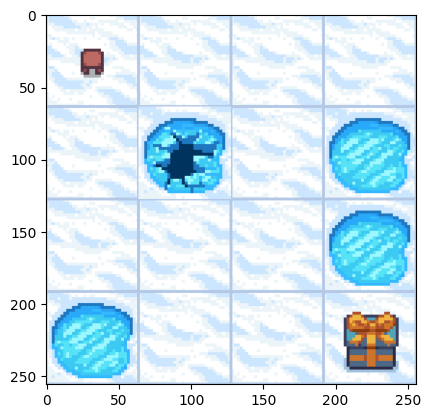

In [ ]:
run_env_random_policy(frozenlake.rendered_env, steps=5)

### 1.1.1 Visualization of the environment

No need to run these cells

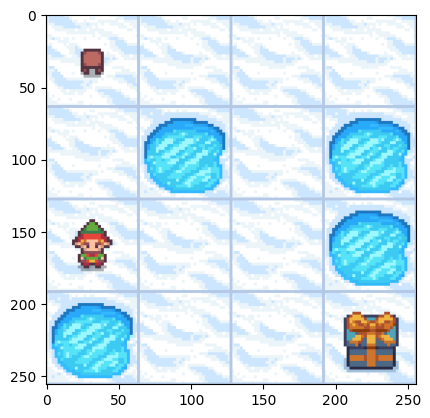

In [ ]:
# visualize the restricted policy
run_env_w_policy(frozenlake.rendered_env, frozenlake.restricted_policy, steps=5)

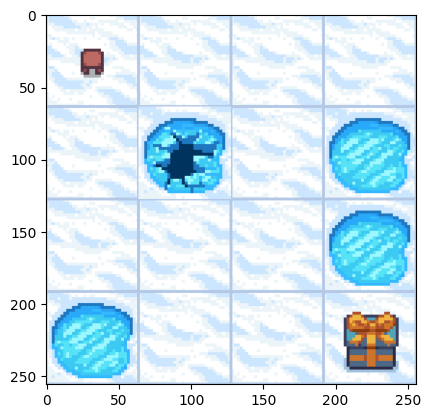

In [ ]:
# visualize the random policy
run_env_w_policy(frozenlake.rendered_env, frozenlake.get_random_policy(), steps=5)

## 1.2. Blackjack environment

Blackjack is a card game where the goal is to beat the dealer by obtaining cards that sum to closer to 21 (without going over 21) than the dealers cards. Blackjack has observation space larger than frozenlake, furthermore, in blackjack, we do not have the access to the transition probabilities.

Therefore, previous methods from the previuos assignment are not applicable here in the case of unknown dynamics.

🛑 <mark>TODO:</mark>

- Read and understand about Blackjack environment's action space, observation space, and rewards from: [here](https://www.gymlibrary.dev/environments/toy_text/blackjack/) (No need to report or write anything to solve this todo)

![alt text](https://www.gymlibrary.dev/_images/blackjack.gif)

In [ ]:
# <DO NOT CHANGE>

env = gym.make("Blackjack-v1")
rendered_env = gym.make("Blackjack-v1", render_mode='rgb_array')
def restricted_policy(observation):
    """
    If the player's score is 20 or greater, stop asking for cards (i.e., return action 0), otherwise,
    ask for another card (i.e., return action 1)

    :param observation: the current state of the game
    :return: The policy is being returned.
    """
    # print(observation)
    score, dealer_score, usable_ace = observation
    return 0 if score >= 20 else 1


# Using 3D surface plotting
def plot_surface_Vfunction(V, title = "Value Function"):
    '''
    Plots the value function as a surface plot.
    '''
    min_x = 11 #min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize = (20, 10))
        ax = fig.add_subplot(111, projection = '3d')
        surf = ax.plot_surface(X, Y, Z, rstride = 1, cstride = 1,
                               cmap = matplotlib.cm.coolwarm, vmin = -1.0, vmax = 1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

# Using heatmap
def plot_Vfunction(V):
    s_dim = (32,11)
    value_mat_false = np.zeros(s_dim)
    value_mat_true = np.zeros(s_dim)
    for k,v in V.items():
        if k[2]:
            value_mat_true[k[0], k[1]] = v
        else:
            value_mat_false[k[0], k[1]] = v

    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(20, 8))

    sns.heatmap(value_mat_false, cmap="flare", center=0.00, annot=True,  linewidths=.5, ax=ax1)
    ax1.set_title('No Usable Ace')

    sns.heatmap(value_mat_true, cmap="flare", center=0.00, annot=True,  linewidths=.5, ax=ax2)
    ax2.set_title('Usable Ace')
    fig.tight_layout()

blackjack = Env("BlackJack", env, rendered_env, restricted_policy, plot_Vfunction)

🛑 <mark>TODO:</mark>

Print action and observation spaces of Blackjack and a sample from the action space

In [ ]:
######## TODO ########
print(env.action_space) # action space
print(env.observation_space) # observation space
print(env.action_space.sample()) # action space's sample
######################

Discrete(2)
Tuple(Discrete(32), Discrete(11), Discrete(2))
0


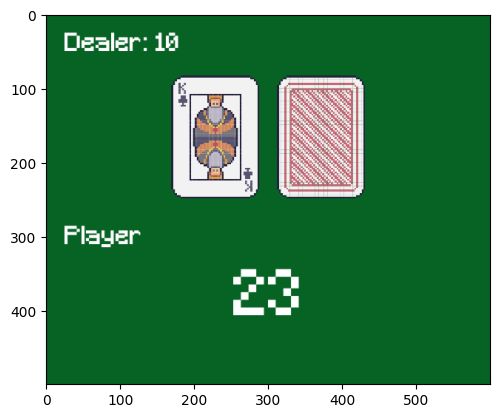

In [ ]:
run_env_random_policy(blackjack.rendered_env, steps=5)

### 1.2.1 Visualization of the environment

No need to run these cells

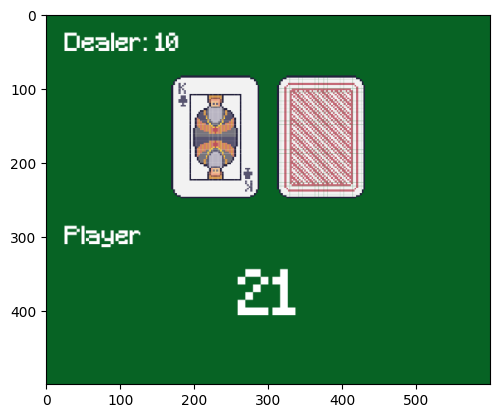

In [ ]:
# visualize the restricted policy
run_env_w_policy(blackjack.rendered_env, blackjack.restricted_policy, steps=5)

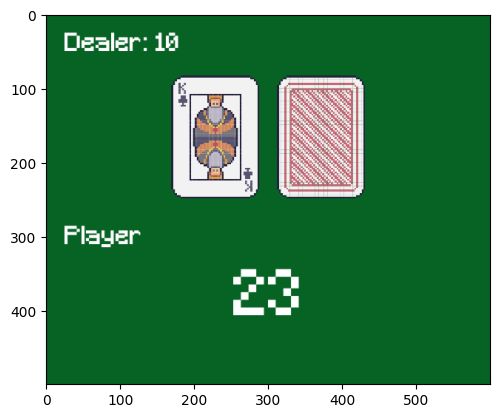

In [ ]:
# visualize the random policy
run_env_w_policy(blackjack.rendered_env, blackjack.get_random_policy(), steps=5)

## 1.3 Cliffwalking environment
It is very similar to frozenlake but with larger observation space

Adapted from Example 6.6 (page 106) from [Reinforcement Learning: An Introduction by Sutton and Barto](http://incompleteideas.net/book/bookdraft2018jan1.pdf).

🛑 <mark> TODO:</mark>

- Read and understand about CliffWalking environment's action space, observation space, and rewards from: [here](https://www.gymlibrary.dev/environments/toy_text/cliff_walking/) (No need to report or write anything to solve this todo)

![alt text](https://www.gymlibrary.dev/_images/cliff_walking.gif)

In [ ]:
# <DO NOT CHANGE>

env = gym.make("CliffWalking-v0")
rendered_env = gym.make("CliffWalking-v0", render_mode='rgb_array')
cliffwalking = Env("CliffWalking", env, rendered_env, plot_dim=(4,12))

### 1.3.1 Visualization of the environment

No need to run these cells

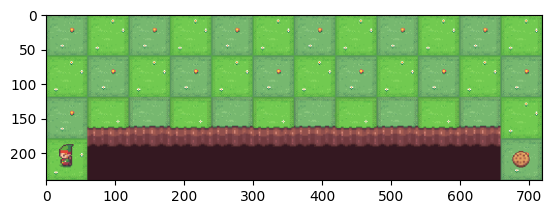

In [ ]:
run_env_random_policy(cliffwalking.rendered_env, steps=5)

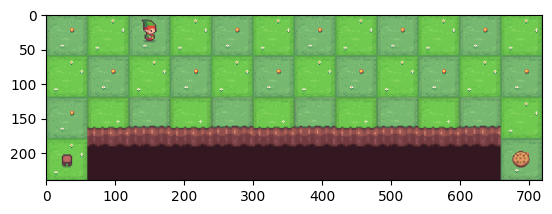

In [ ]:
# visualize the restricted policy
run_env_w_policy(cliffwalking.rendered_env, cliffwalking.restricted_policy, steps=5)

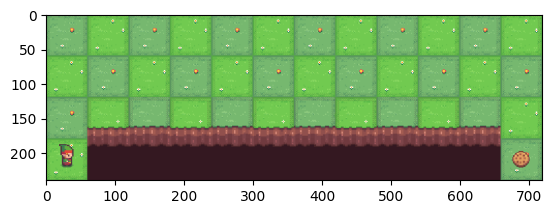

In [ ]:
# visualize the random policy
run_env_w_policy(cliffwalking.rendered_env, cliffwalking.get_random_policy(), steps=5)

# 2. Monte-Carlo

Monte-Carlo (MC) learns from episodes of raw experience without modeling the environmental dynamics and computes the observed mean return as an approximation of the expected return. As, in the case of MDP with unknown dynamics in which Dynamic Programming methods are not able to be used.

To compute the empirical return $G_t$, MC methods need to learn from **complete** episodes to compute $$G_t=\sum_{k=0}^{T-t-1}\gamma^kR_{t+k+1}$$ and all the episodes must eventually terminate.

## 2.1 MC Prediction

Here, we are intrested to evaluate a policy by computing the value functions.

In this assignment, we are interested to predict the state-value function $V(s)$, and it can be estimated through the following equation:

$$V(s) = \frac{\sum_{t=1}^{T}\mathbb{1}[S_t = s] G_t}{\sum_{t=1}^{T}\mathbb{1}[S_t = s]}$$

### 2.1.1 First-visit predicition

There are two ways for MC predicition:

1. Every-visit predicition: We may count the visit of state s every time so that there could exist multiple visits of one state in one episode
2. First-visit predicition: only count it the first time we encounter a state in one episode


In this assignment, we are only interested in First-visit method


🛑 <mark>TODO:</mark>
In the following section, you are required to implement Monte-Carlo First-Visit Prediction

In [ ]:
# Hint: RL Sutton book, 5.1
def mc_prediciton_first_visit(policy, env_obj, num_episodes, episode_length=100, discount_factor=1.0, seed=SEED):
    """
    > For each episode, we find the first visit of each state, and then calculate the return of the
    state based on the first visit

    :param policy: The policy to be evaluated
    :param env_obj: The environment object that include a gym environment to run the algorithm on
    :param num_episodes: The number of episodes to run
    :param episode_length: The length of each episode, defaults to 100 (optional)
    :param discount_factor: The discount factor for the MDP
    :param seed: The random seed to use for the environment
    :return: The value function as a dictionary with keys with size and values
    """
    env = env_obj.env
    fix_seed(env, seed)

    # Storing the value fucntion table
    V = defaultdict(float)
    # Hint: You can access the elements in V like this: V[state] = scalar
    #       in which the state can be a tuple

    ######## TODO ########
    vorn = defaultdict(int)
    vnum = defaultdict(int)
    cur_epinum = 0
    while(cur_epinum <= num_episodes):
      cur_epinum = cur_epinum + 1
      cur_epi = rollout(policy, env, episode_length)
      epi_len = compute_episode_length(cur_epi)
      ret = compute_episode_return(cur_epi, discount_factor)
      for i in range(epi_len):
        st = cur_epi[i][0]
        if(vorn[st] != 1):
          vorn[st] = 1
          vnum[st] = vnum[st] + 1
          V[st] = V[st] + (ret - V[st])/vnum[st]
      vorn.clear()
    ######################
    return V

#### 2.1.1.1 Blackjack environment

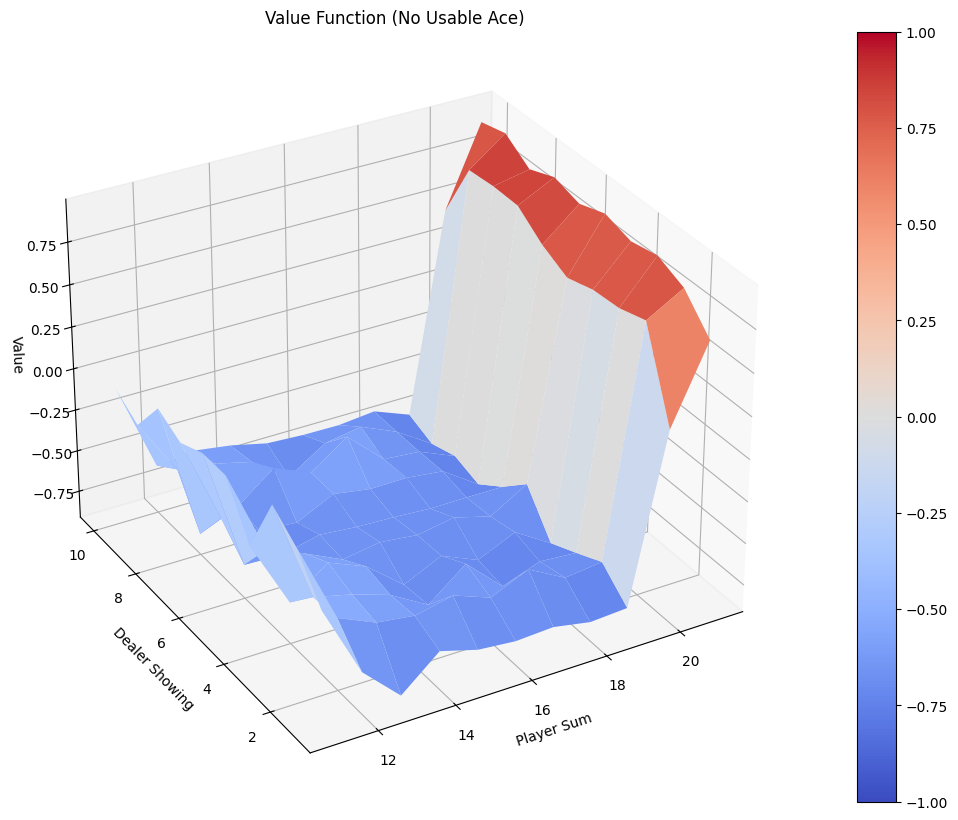

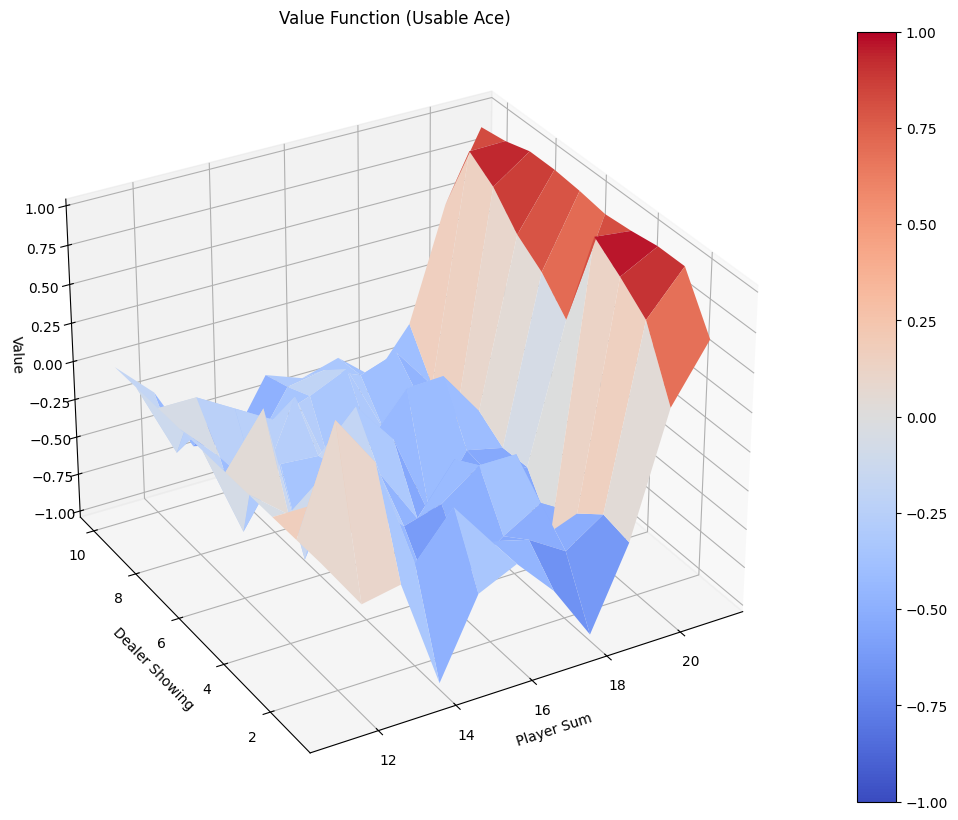

In [ ]:
V = mc_prediciton_first_visit(blackjack.restricted_policy, blackjack, num_episodes=10000)
# blackjack.plot_Vfunction(V)
plot_surface_Vfunction(V)

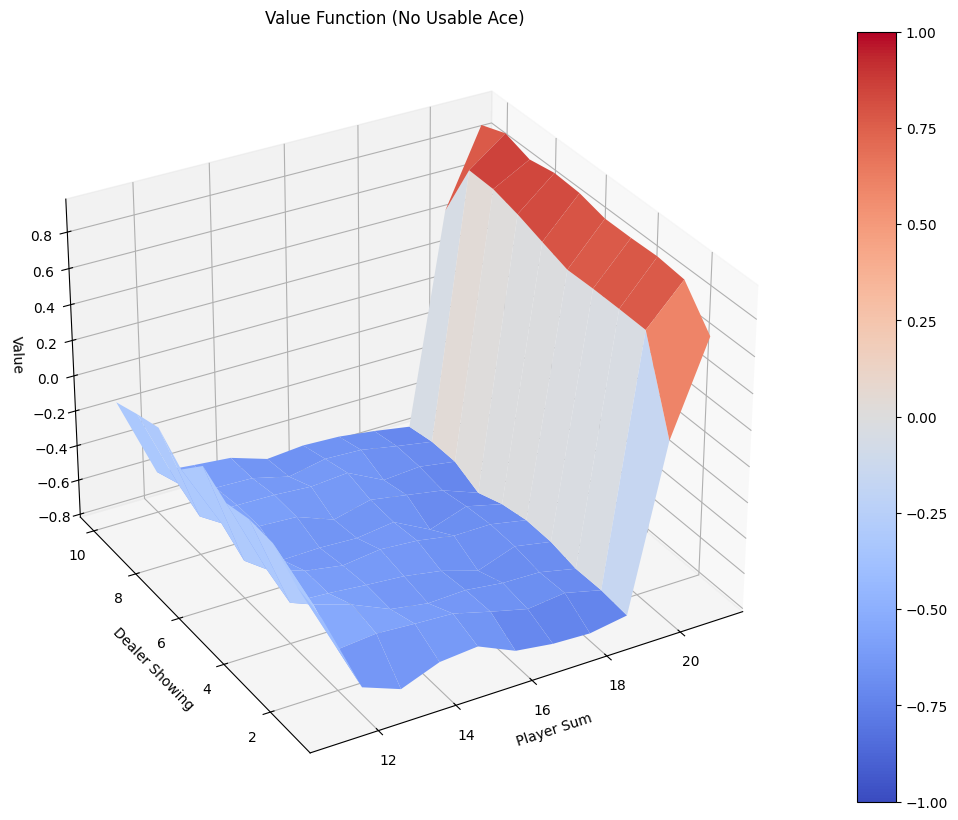

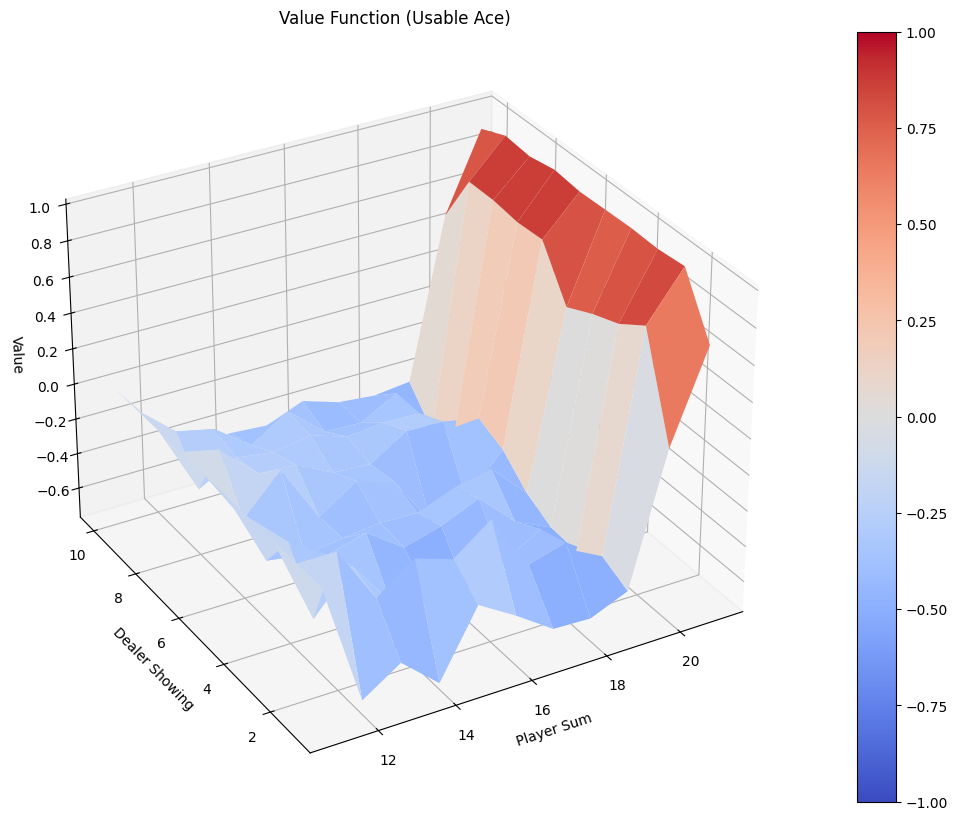

In [ ]:
V = mc_prediciton_first_visit(blackjack.restricted_policy, blackjack.env, num_episodes=50000)
# blackjack.plot_Vfunction(V)
plot_surface_Vfunction(V)

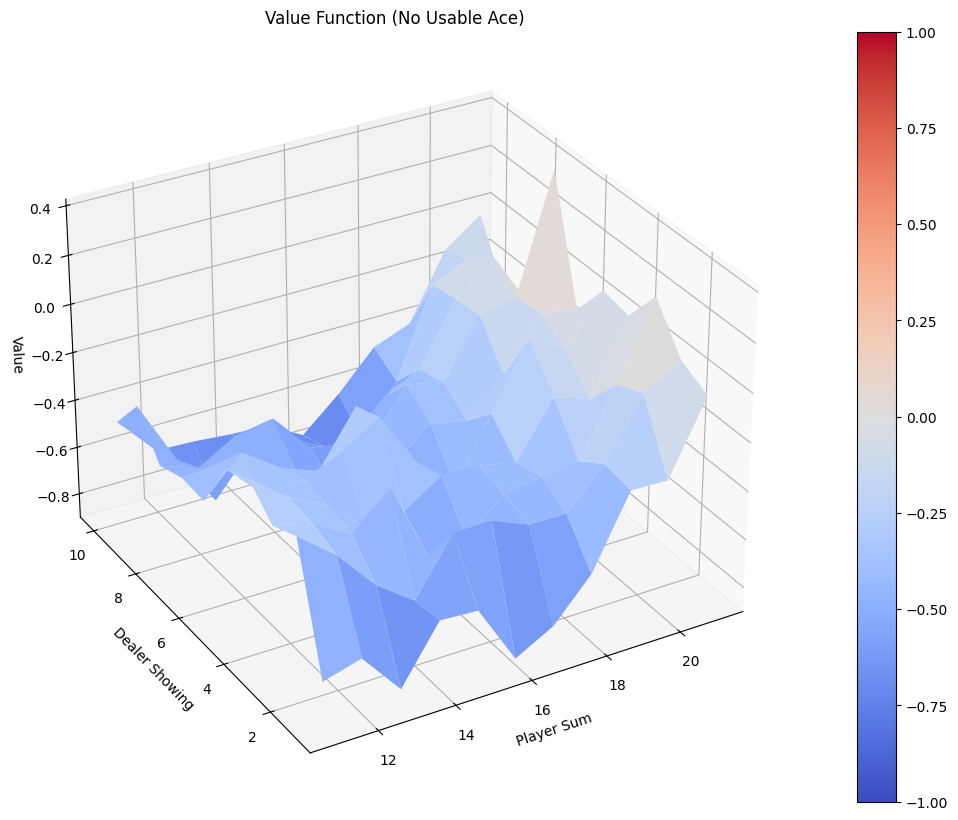

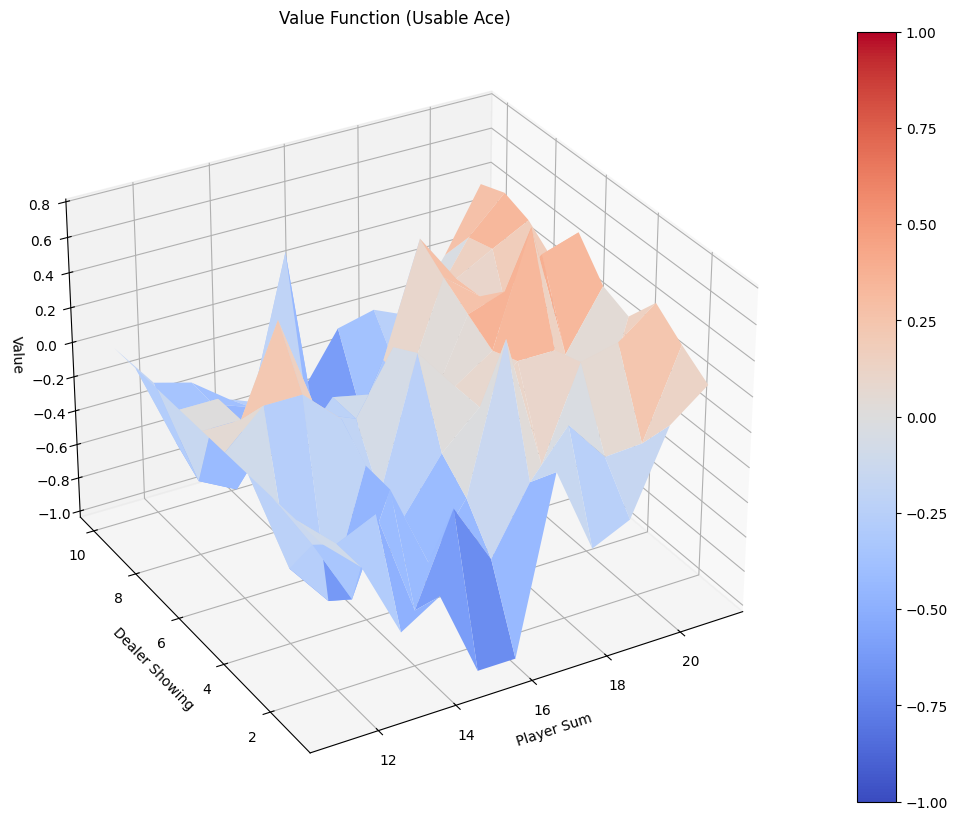

In [ ]:
V = mc_prediciton_first_visit(blackjack.get_random_policy(), blackjack, num_episodes=10000)
# blackjack.plot_Vfunction(V)
plot_surface_Vfunction(V)

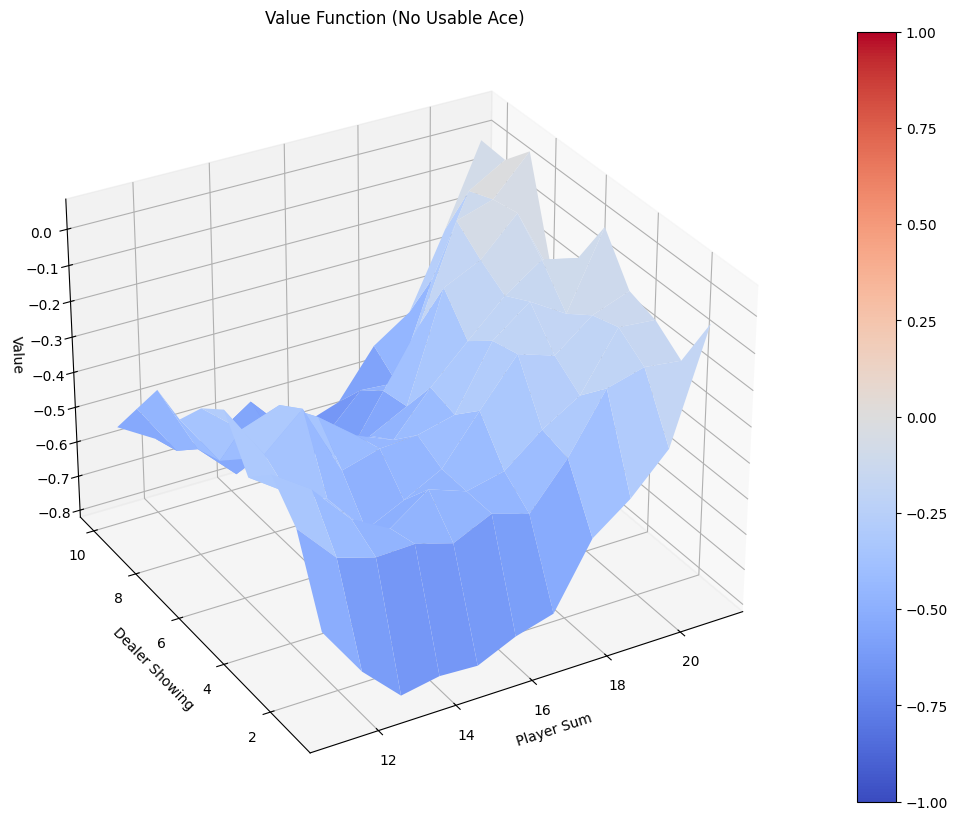

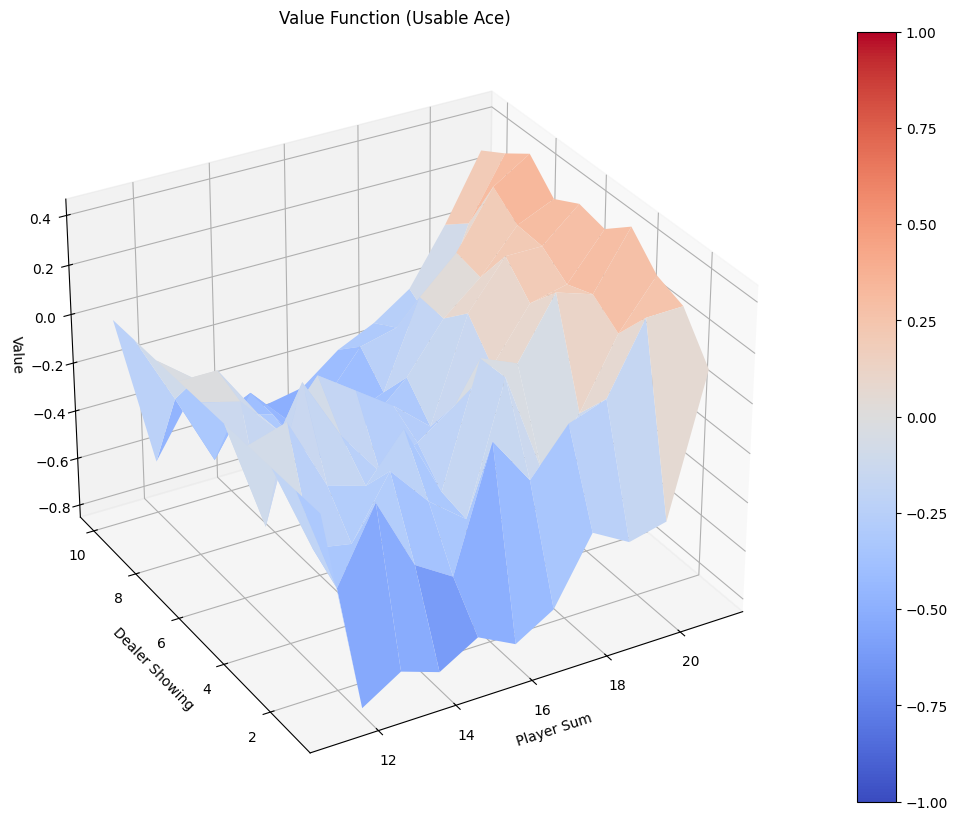

In [ ]:
V = mc_prediciton_first_visit(blackjack.get_random_policy(), blackjack, num_episodes=50000)
# blackjack.plot_Vfunction(V)
plot_surface_Vfunction(V)

#### 2.1.1.2 Frozenlake environment

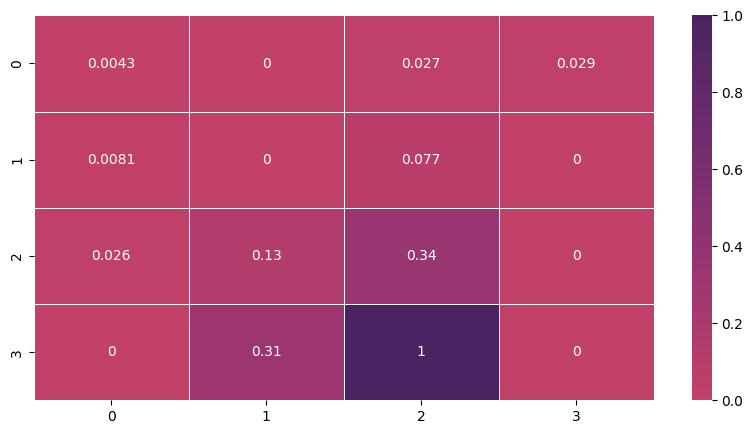

In [ ]:
V = mc_prediciton_first_visit(frozenlake.get_random_policy(), frozenlake, num_episodes=500)
frozenlake.plot_Vfunction(V)

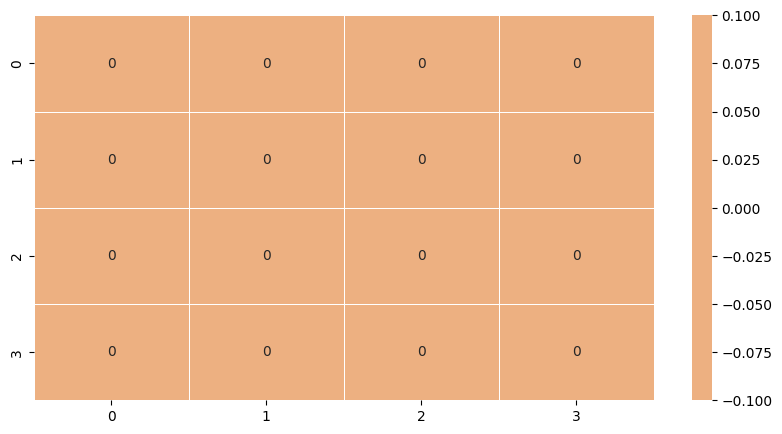

In [ ]:
V = mc_prediciton_first_visit(frozenlake.restricted_policy, frozenlake, num_episodes=500)
frozenlake.plot_Vfunction(V)

🛑 <mark>TODO:</mark>
Answer the following question in the following cell:

Q: What is the reason that the predicted value function of the restricted policy is full of zeros while the random policy is not?


--------------

🛑 <mark>TODO: Answer</mark>

Because the restricted policy for FrozenLake envrionment have actions which less than half of the max action of action space. It mean restricted policy have only 0 and 1 action which make agent move left or down. This make agent can't reach the reward +1 state which located at rightmost bottom. And the values in value function can not change and all entry keep it's value 0.

(No more than 100 words)

--------------



## 2.2 MC Control

MC control is concerned to learn the optimal policy by simply evaluating the policy

### 2.2.1 Epsilon-Greedy

In [ ]:
# <DO NOT CHANGE>

def epsilon_greedy_policy_fn(observation, Q, epsilon, env):
    """
    It takes in an observation, a Q-table, an epsilon value, and an environment, and returns an action

    :param observation: the current state of the environment
    :param Q: The Q-table
    :param epsilon: the probability of taking a random action
    :param env: the environment
    :return: The action that is being returned is the action that is being taken by the agent.
    """
    action = None
    if np.random.rand() < epsilon:
        # random action
        action = env.action_space.sample()
    else:
        # best action
        action = np.argmax(Q[observation])
    return action

🛑 <mark>TODO:</mark>
In the following section, you are required to implement Monte-Carlo Control using the epsilon greedy policy based on first-visit

In [ ]:
# Hint: https://web.stanford.edu/class/cs234/slides/lecture4post.pdf
def mc_control_epsilon_greedy(env_obj, num_episodes, episode_length=100, discount_factor=1.0, epsilon=0.1, seed=SEED):
    """
    For each episode, we generate a rollout using the epsilon-greedy policy, and then we update the
    action-value function with the return using first-visit Monte Carlo method.

    :param env_obj: The environment object that include a gym environment to run the algorithm on
    :param num_episodes: The number of episodes to run
    :param episode_length: The length of each episode, defaults to 100 (optional)
    :param discount_factor: The discount factor for the MDP
    :param epsilon: The probability of selecting a random action. Float between 0 and 1
    :param seed: The random seed to use for the environment
    :return:
        * Q-function: a dictionary, such that the key is (state, action) and the value is the action-state-value
        * policy: an epsilon greedy policy used during the training based on the computed Q-table
        * stats: a dictionary, such that it has two keys rew & len, and the values are the total reward and length of the episode, respectively.
    """
    env = env_obj.env
    fix_seed(env, seed)
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Hint: You can access the elements in Q like this: Q[state][action]

    # Store the reward and length of episodes during the running of the method
    stats = defaultdict(list)

    ######## TODO ########
    # Note (Important):
    vorn = defaultdict(lambda: np.zeros(env.action_space.n))
    vnum = defaultdict(lambda: np.zeros(env.action_space.n))
    cur_epinum = 0
    policy = partial(epsilon_greedy_policy_fn, Q=Q, epsilon=epsilon, env=env)
    while(cur_epinum <= num_episodes):
      cur_epinum = cur_epinum + 1
      cur_epi = rollout(policy, env, episode_length)
      epi_len = compute_episode_length(cur_epi)
      ret = compute_episode_return(cur_epi, discount_factor)
      stats["rew"].append(ret)
      stats["len"].append(epi_len)
      for i in range(epi_len):
        st = cur_epi[i][0]
        act = cur_epi[i][1]
        if(vorn[st][act] != 1):
          vorn[st][act] = 1
          vnum[st][act] = vnum[st][act] + 1
          Q[st][act] = Q[st][act] + (ret - Q[st][act])/vnum[st][act]
      vorn.clear()
    # For each episode, make sure that you call:
    # stats["rew"].append(compute_episode_return(episode))
    # stats["len"].append(compute_episode_length(episode))
    # such that episode is a list such that each element is a list of [state, action, reward, next_state]
    #   Example: [[s1,a1,r1,s2], [s2,a2,r2,s3], ....]

    #   Hint: episode is the return of calling rollout()
    #   Hint: you can use: policy = partial(epsilon_greedy_policy_fn, Q=Q, epsilon=epsilon, env=env)


    ######################
    return Q, policy, stats

#### 2.2.1.1 Blackjack environment

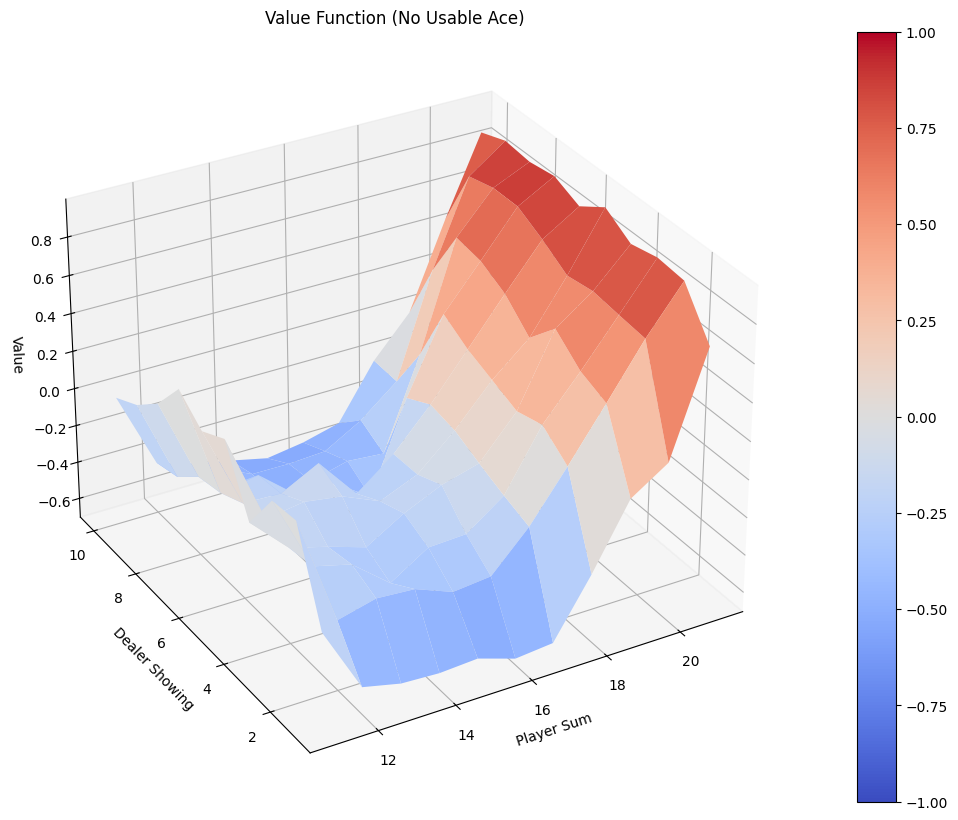

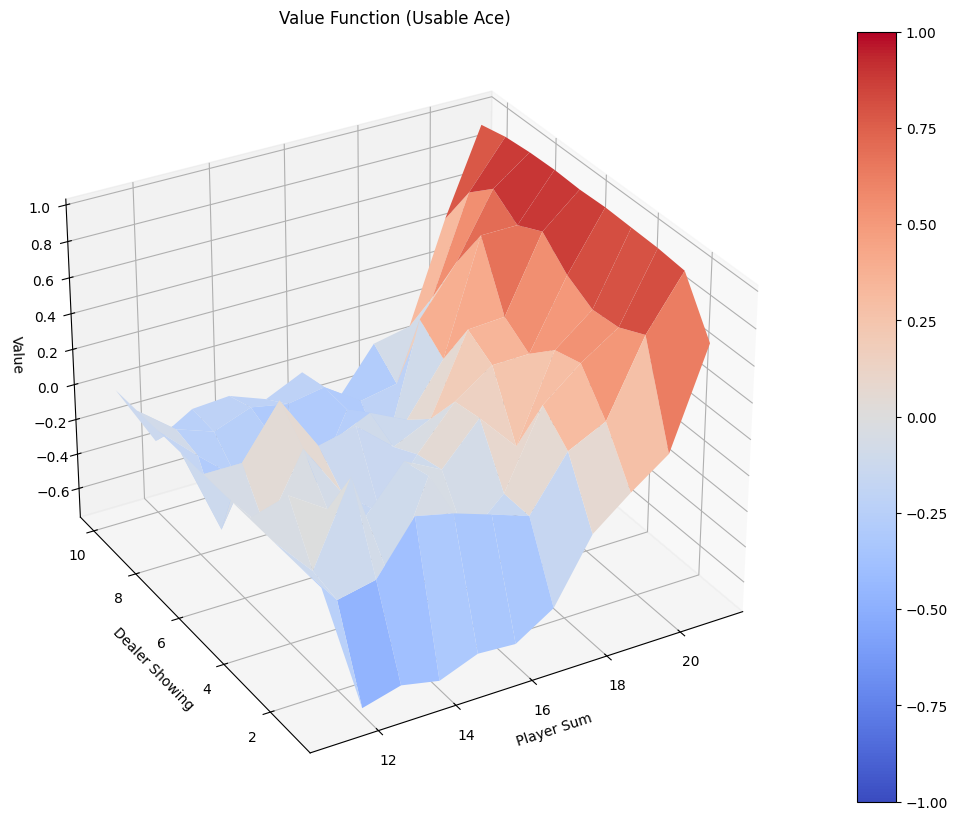

In [ ]:
Q, policy, stats = mc_control_epsilon_greedy(blackjack, num_episodes=50000, epsilon=0.1)
# Create value function from action-value function by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
# blackjack.plot_Vfunction(V) # if you want to see it in heatmap
plot_surface_Vfunction(V)

#### 2.2.1.2 Frozenlake environment

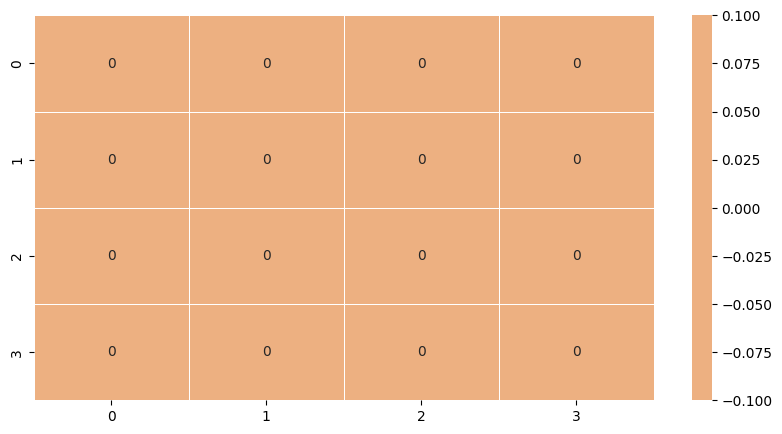

In [ ]:
Q, policy, stats = mc_control_epsilon_greedy(frozenlake, num_episodes=50000, epsilon=0.1)
# Create value function from action-value function by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
frozenlake.plot_Vfunction(V)


🛑 <mark>TODO:</mark>

Answer the following question in the following cell:

Q: Does it give you a matrix full of zeros? If yes, explain why?

Q: Try to change epsilon in the following code cell, then explain why that happened!

Q: And is it an optimal policy? and why?



--------------

🛑 <mark>TODO: Answer</mark>

A1. It give me a matrix full of zeros. I think If the epsilon is 0.1, then the agent do random action with probabilty 0.1. And this make the agent can not do the enough exploaration to reach the reward +1 state which located rightmost bottom. Before reaching the +1 state, all state and action value pair have 0 value. Therefore there are no meanings for choosing greedy action. And the 0,1 epsilon is too low because this environment always start at 0 state.

A2. If epsilon is above 1, the agent do not eploitation. So the result is almost same with random action policy(slightly different becuase of the "random action" for every trial we run). And the value of each states keep increase if I keep setting the epsilon lower and lower. It is because the rate of exploitation keep increase and it make the value increased.

A3. Setting epsilon to too low value can not make agent to exploration and it make agent to reach new state that agent never reached. This can cause the return update hard. On the other side, too high epsilon mainly choose the random action and hard to choose the best action in collected data. This make the policy very similar to random action. Therefore we should choose epsilon value very well. If epsilon value is appropriate, then the policy can be optimal policy.


(No more than 100 words for each question)


--------------


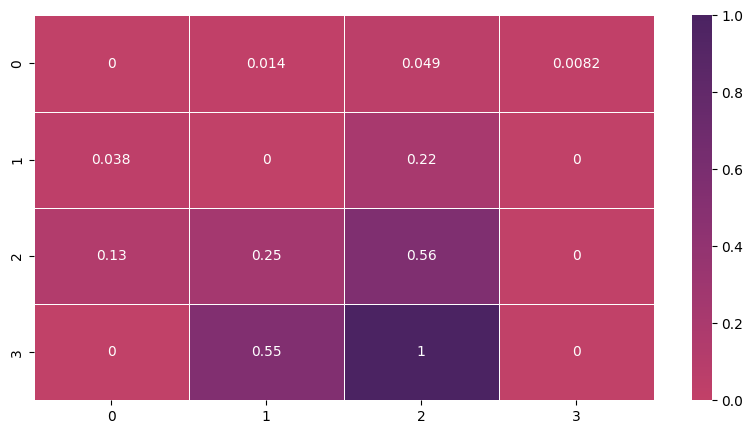

In [ ]:
######## TODO ########
epsilon = 0.9
Q, policy, stats = mc_control_epsilon_greedy(frozenlake, num_episodes=50000, epsilon=epsilon)
# Create value function from action-value function by picking the best action at each state
V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
frozenlake.plot_Vfunction(V)
######################

# 3. Temporal-Difference Learning

Starting from here, we are going to experiment with cliffwalking environment.

Similar to Monte-Carlo methods, Temporal-Difference (TD) Learning is model-free and learns from episodes of experience. However, TD learning can learn from incomplete episodes and hence we don’t need to track the episode up to termination. TD learning is so important that Sutton & Barto (2017) in their RL book describes it as “one idea … central and novel to reinforcement learning”.


## 3.1 TD(0) Prediction

For TD(0)'s target $=R_{t+1}+\gamma V(S_{t+1})$. Therefore, the state-value function can be estimated: $$V(S_t) ← V(S_t) + \alpha \left[R_{t+1} + \gamma V(S_{t+1}) - V(S_t)\right]$$

🛑 <mark>TODO:</mark>

Answer the following question in the following cell:

Q: What is the state-value function update rule of Monte-Carlo every-visit predicition, Monte-Carlo First-visit predicition, TD(0), TD(1), and TD($\lambda$)?

--------------

🛑 <mark>TODO: Answer</mark>

Monte-Carlo every-visit prediction: Track the episode up to termination and collect state's return value every time it reach that state in one episode.

Monte-Carlo First-visit prediction: This collect the return value only at the first time when agent reach that state in one episode.

TD(0): Track just one step and can use the one-step reward and estimated return to update state-value function with this value.

TD(1): Track all steps untill the episode end, And get the return value with this track and update the state-value function with this value.

TD(λ): Agent track λsteps and get the return with rewards and estimated value function at the reached state and update state-value function with it.

(No more than 100 words)

--------------


🛑 <mark>TODO:</mark>
In the following section, you are required to implement TD(0)

In [ ]:
# Hint: RL Sutton book, 6.1
def TD0(policy, env_obj, num_episodes, episode_length=100, discount_factor=1.0, seed=SEED, alpha=0.5, verbose=True):
    """
    > For each episode, we run a rollout and update the value function for each state in the episode
    following TD(0) method

    :param policy: the policy to be evaluated
    :param env_obj: The environment object that include a gym environment to run the algorithm on
    :param num_episodes: number of episodes to run
    :param episode_length: The number of steps in each episode, defaults to 100 (optional)
    :param discount_factor: The discount factor for the MDP
    :param seed: The random seed used to generate the episode
    :param alpha: learning rate
    :param verbose: If True, it will plot the value function every 10% of the episodes, defaults to True
    (optional)
    :return: The value function table
    """
    env = env_obj.env
    logging_freq = int(num_episodes*0.1)
    fix_seed(env, seed)

    # Storing the value fucntion table
    V = defaultdict(float)

    ######## TODO ########
    # Note (Important):
    cur_epinum = 0
    while(cur_epinum <= num_episodes):
      cur_epinum = cur_epinum + 1
      cur_epi = rollout(policy, env, episode_length)
      epi_len = compute_episode_length(cur_epi)
      ret = compute_episode_return(cur_epi, discount_factor)

      for i in range(epi_len-1):
        st = cur_epi[i][0]
        reward = cur_epi[i][2]
        st1 = cur_epi[i][3]
        V[st] = V[st] + alpha*(reward + discount_factor*V[st1] - V[st])
      if verbose and (cur_epinum)%logging_freq == 0:
        env_obj.plot_Vfunction(V)
    # For each episode, make sure that you call:
    # * if verbose and (episode_idx+1)%logging_freq == 0:
    #       env_obj.plot_Vfunction(V)


    # Hint: V dictionary has the following form to access its values: V[state]


    ######################
    return V

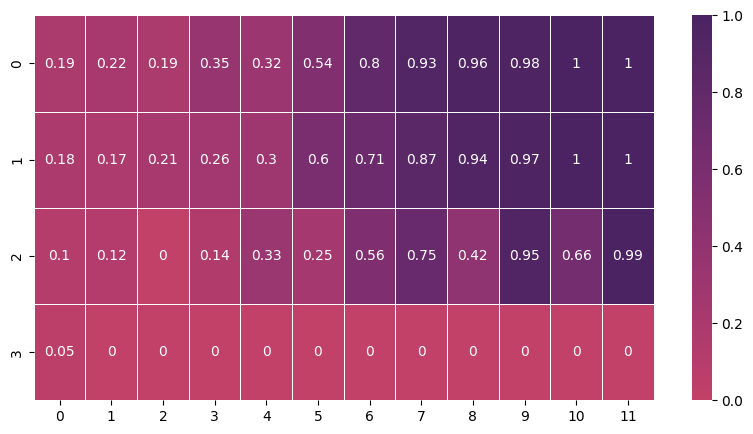

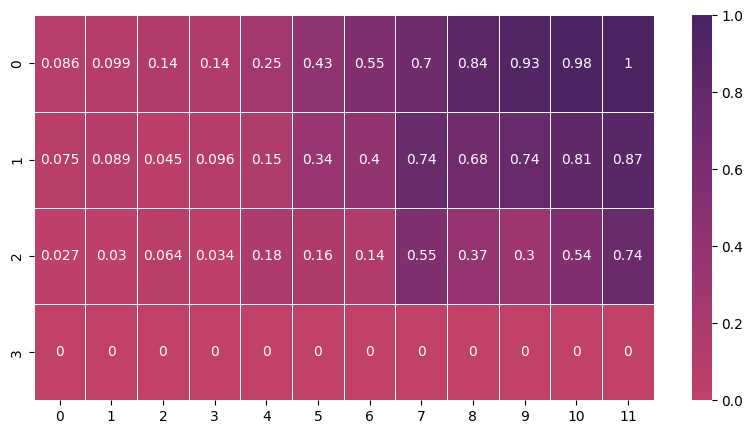

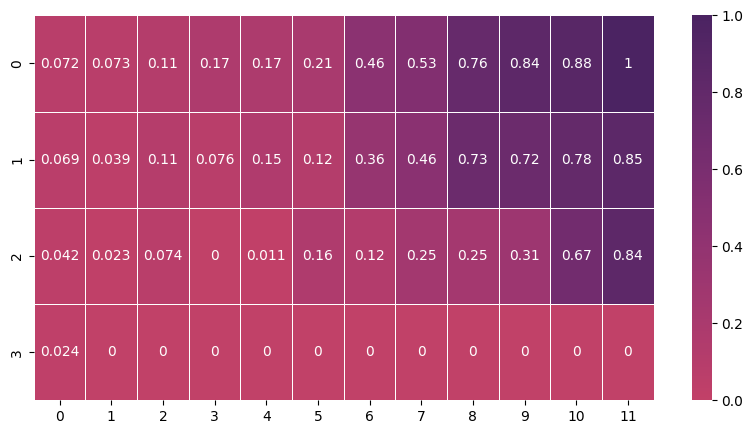

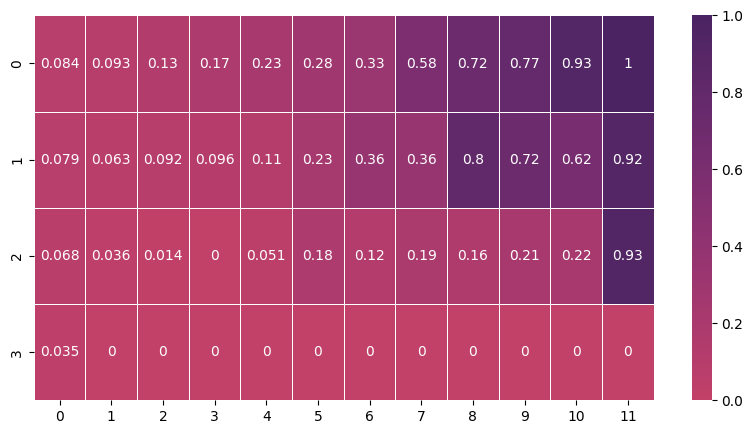

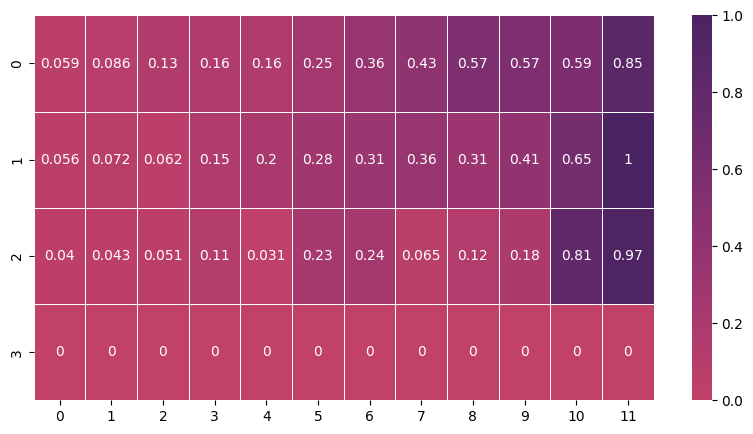

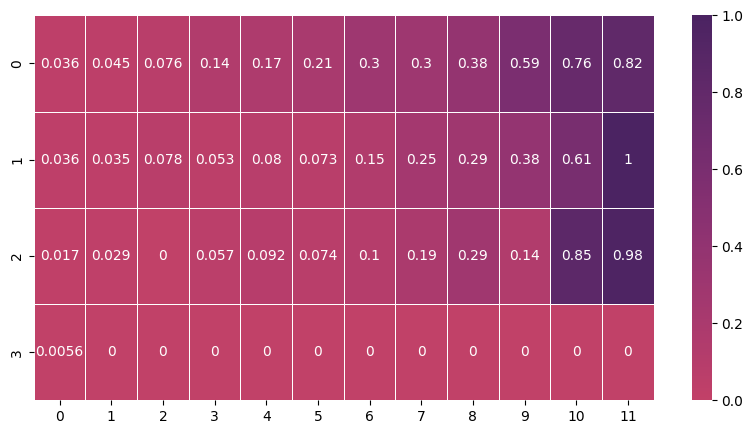

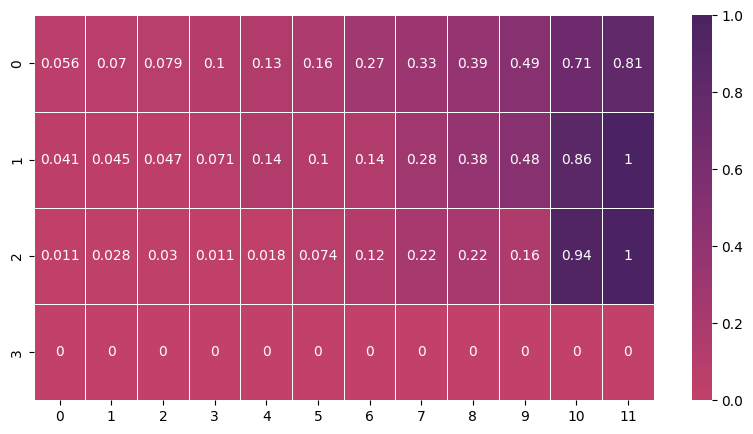

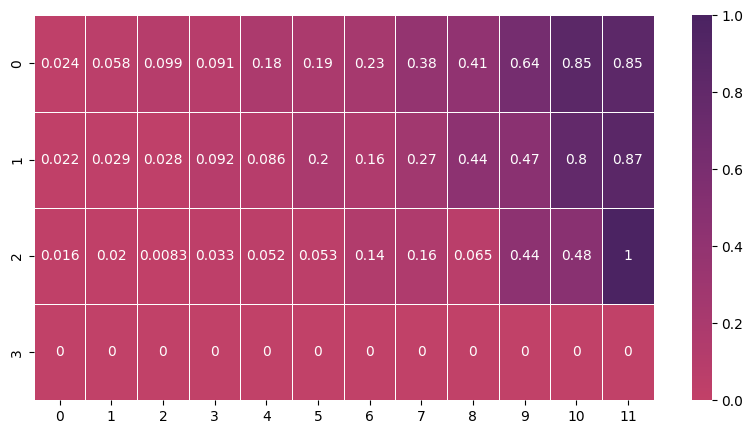

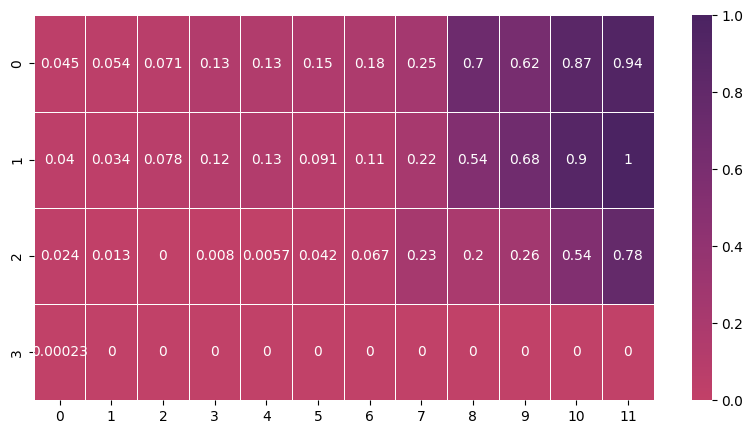

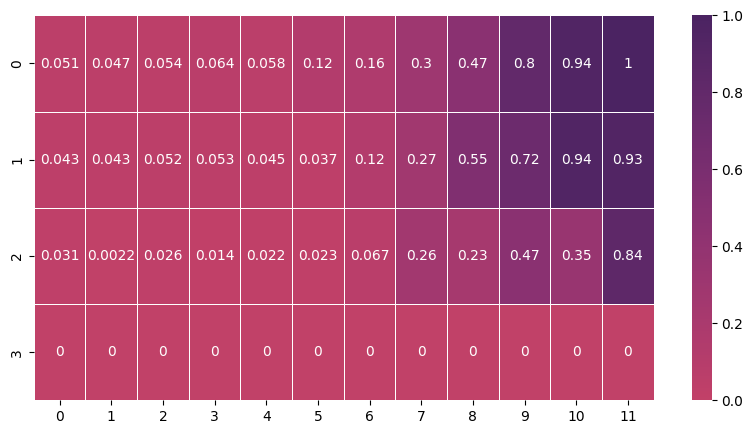

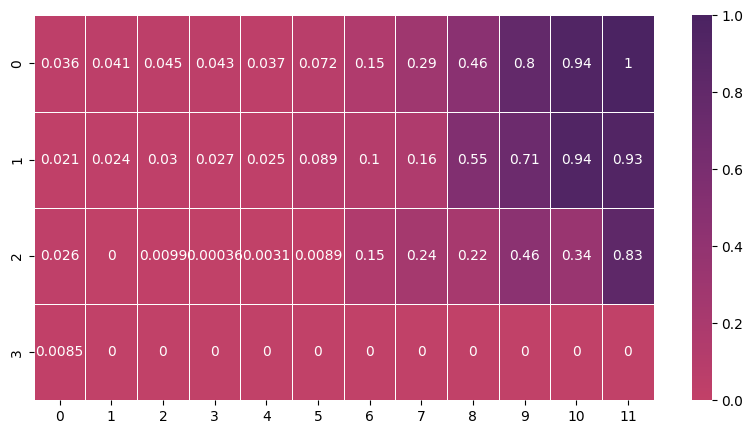

In [ ]:
V = TD0(cliffwalking.get_random_policy(), cliffwalking, num_episodes=1000)
cliffwalking.plot_Vfunction(V)

## 3.2 Q-Learning (Off-policy TD control)


$$Q(s, a) \leftarrow Q(s, a) + α * (r + γ * max(Q(s', a')) - Q(s, a))$$

Where:
- Q(s, a): the current Q-value for state 's' and action 'a'
- α: the learning rate (0 <= α <= 1)
- r: the immediate reward for taking action 'a' in state 's'
- γ: the discount factor (0 <= γ <= 1)
- max(Q(s', a')): the maximum Q-value for the next state 's' and any possible action 'a'

🛑 <mark>TODO:</mark>
In the following section, you are required to implement Q-Learning

In [ ]:
# Hint: RL Sutton book, 6.5

def QLearning(env_obj, num_episodes, episode_length=100, discount_factor=1.0, epsilon=0.1, seed=SEED, alpha=0.5, verbose=True):
    """
    > For each episode, we run a loop for a maximum of `episode_length` steps. In each step, we take an
    action according to the epsilon-greedy policy, observe the reward and next state, and update the
    Q-value of the state-action pair

    :param env_obj: The environment object that include a gym environment to run the algorithm on
    :param num_episodes: number of episodes to run
    :param episode_length: The maximum length of an episode, defaults to 100 (optional)
    :param discount_factor: The discount factor for the MDP
    :param epsilon: the probability of choosing a random action
    :param seed: The random seed to use for the environment
    :param alpha: learning rate
    :param verbose: If True, it will print the progress of the algorithm each specific frequency, defaults to True (optional)
    :return:
        * Q-function: a dictionary, such that the key is (state, action) and the value is the action-state-value
        * policy: an epsilon greedy policy used during the training based on the computed Q-table
        * stats: a dictionary, such that it has two keys rew & len, and the values are the total reward and length of the episode, respectively.
    """
    env = env_obj.env
    logging_freq = int(num_episodes*0.1)
    fix_seed(env, seed)
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Store the reward and length of episodes during the running of the method
    stats = defaultdict(list)

    ######## TODO ########
    # Note (Important):

    cur_epinum = 0
    policy = partial(epsilon_greedy_policy_fn, Q=Q, epsilon=epsilon, env=env)
    while(cur_epinum <= num_episodes):
      cur_epinum = cur_epinum + 1
      cur_epi = rollout(policy, env, episode_length)
      epi_len = compute_episode_length(cur_epi)
      ret = compute_episode_return(cur_epi, discount_factor)
      stats["rew"].append(ret)
      stats["len"].append(epi_len)
      for i in range(epi_len-1):
        st = cur_epi[i][0]
        act = cur_epi[i][1]
        reward = cur_epi[i][2]
        st1 = cur_epi[i][3]
        nextmax = np.max(Q[st1])
        Q[st][act] = Q[st][act] + alpha*(reward + discount_factor*nextmax - Q[st][act])
      if verbose and (cur_epinum)%logging_freq == 0:
        env_obj.plot_Vfunction_from_Q(Q)

    # For each episode, make sure that you call:
    # * stats["rew"].append(cumulative_reward)
    # * stats["len"].append(episode_length)
    # Such that cumulative_reward is the total reward in the episode
    #  and episode_length stores the length of the episode
    # * if verbose and (episode_idx+1)%logging_freq == 0:
    #       env_obj.plot_Vfunction_from_Q(Q)

    # Hint: you can use: policy = partial(epsilon_greedy_policy_fn, Q=Q, epsilon=epsilon, env=env)

    # Hint: Q dictionary has the following form to access its values: Q[state][action]

    ######################

    return Q, policy, stats

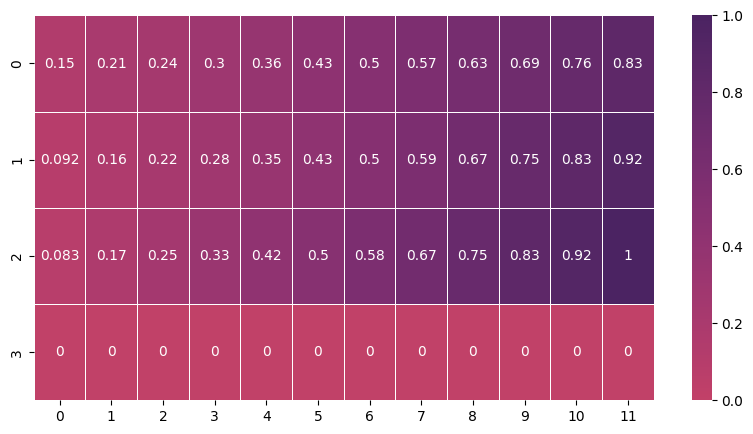

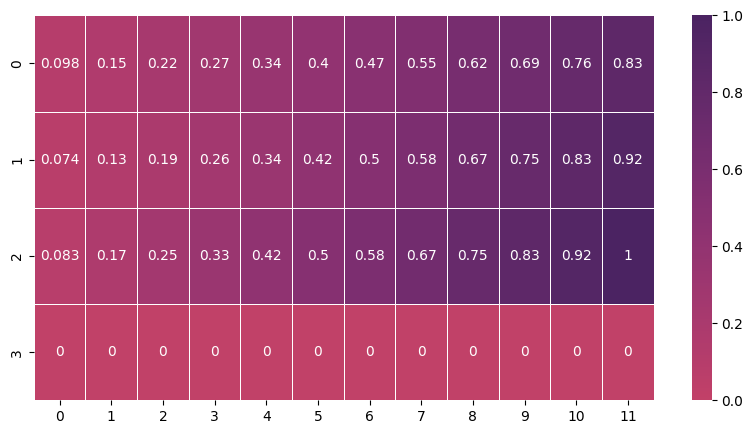

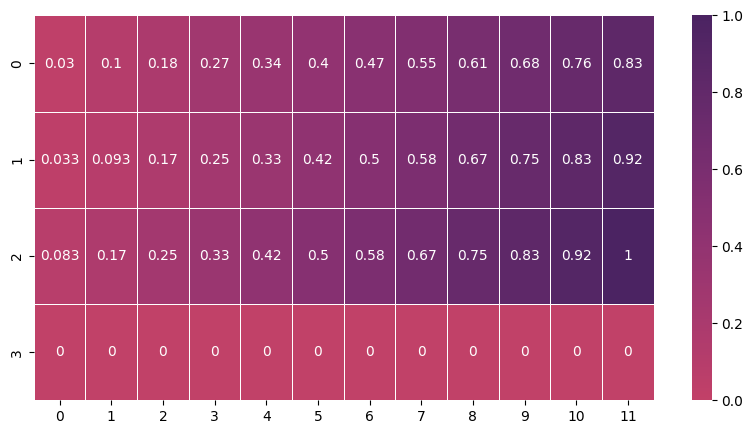

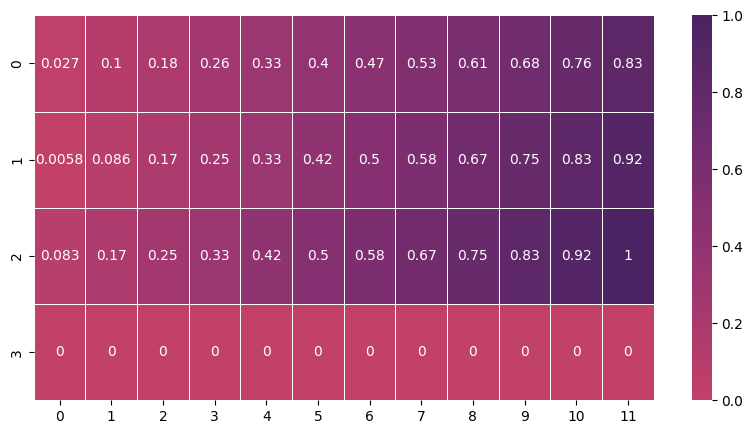

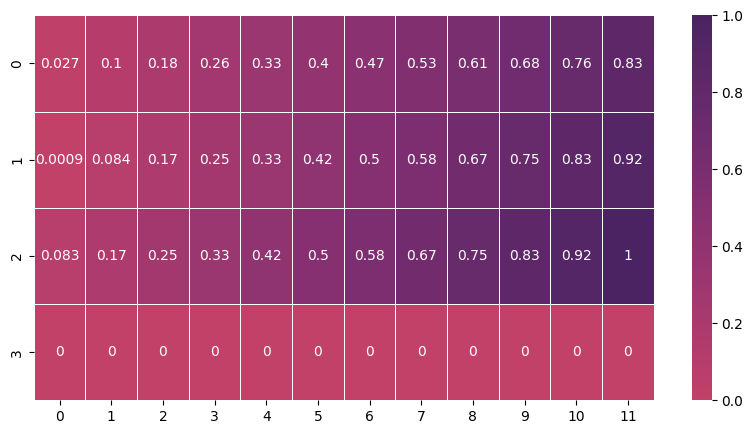

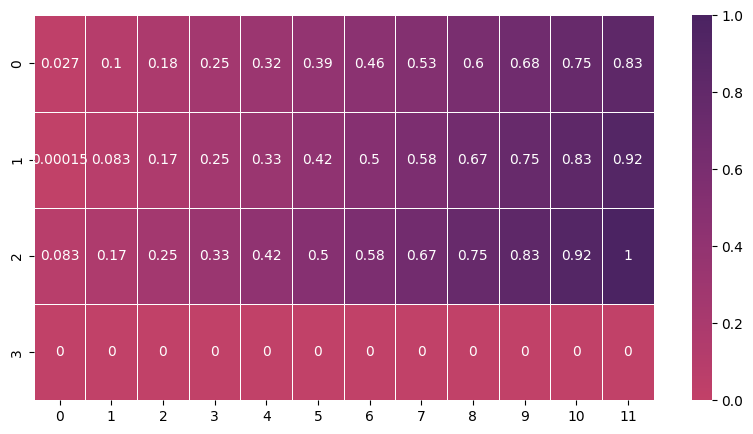

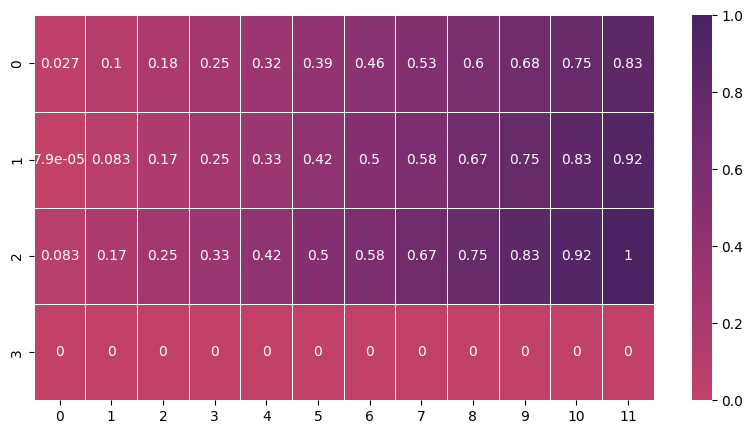

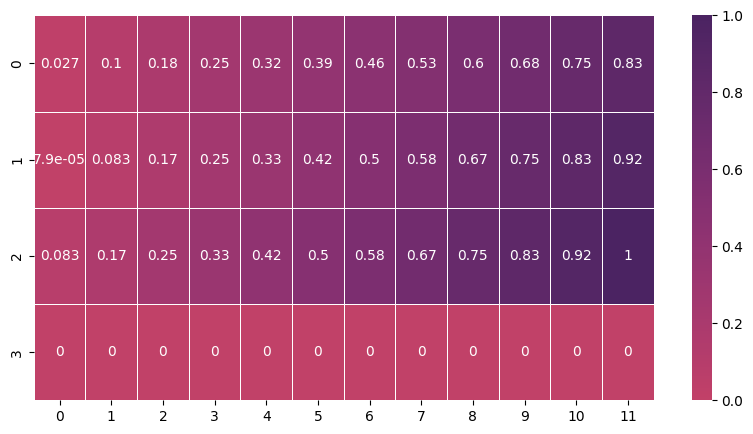

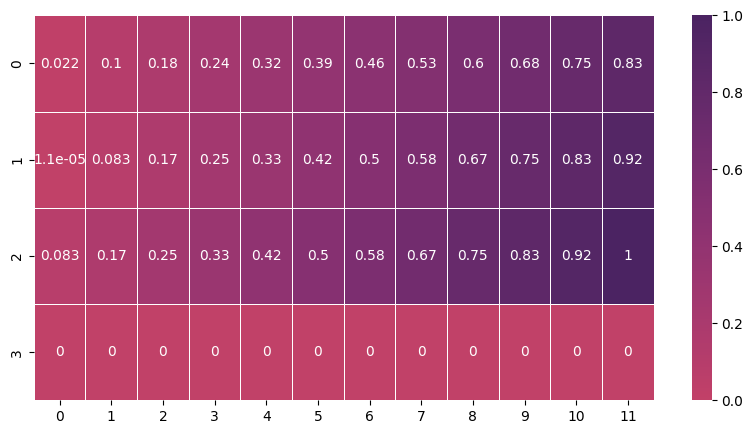

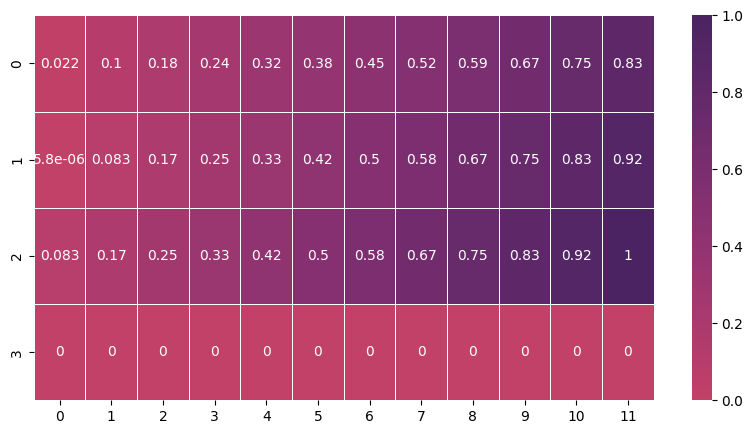

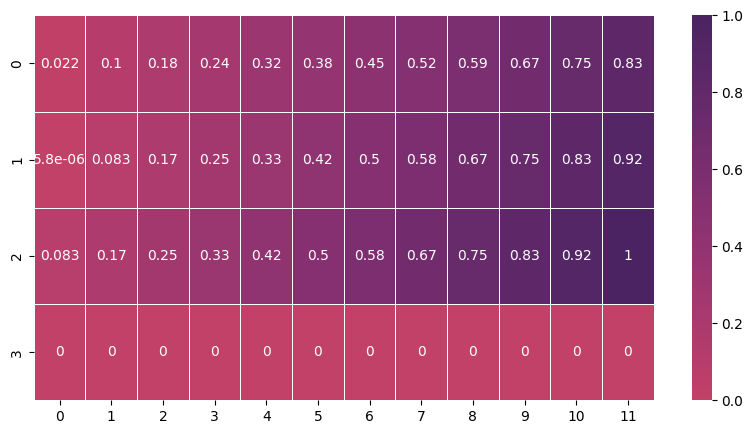

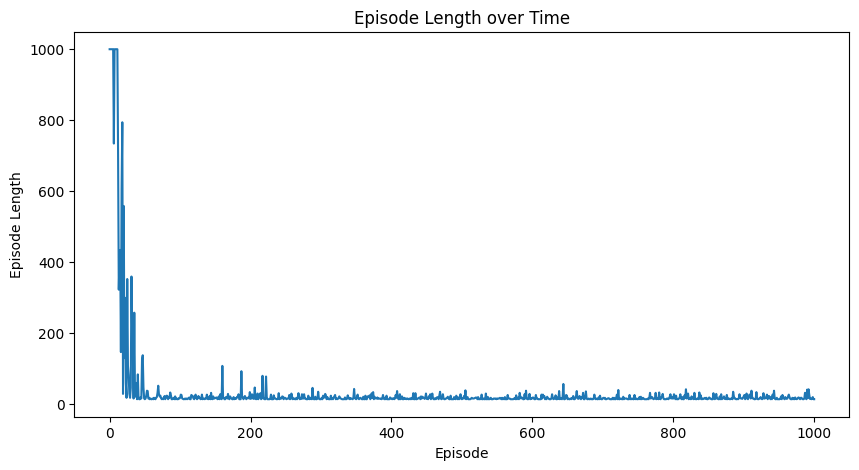

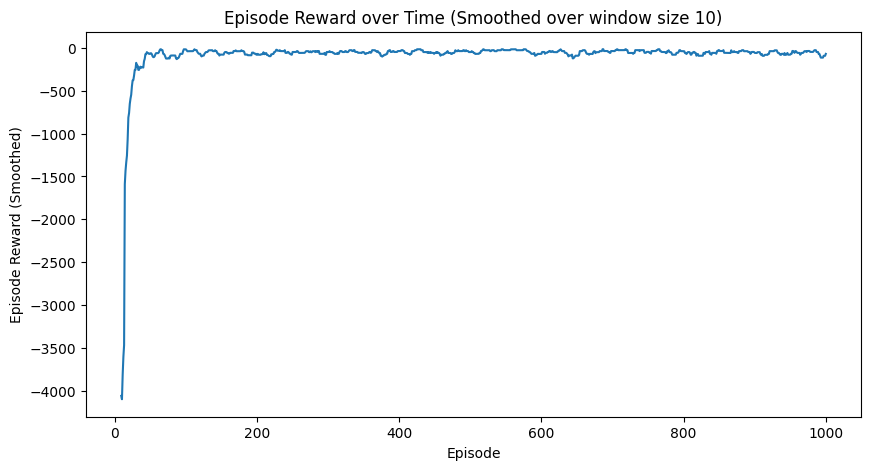

(<Figure size 1000x500 with 1 Axes>, <Figure size 1000x500 with 1 Axes>)

In [ ]:
env_obj = cliffwalking
qlearning_Q, policy, stats = QLearning(env_obj, num_episodes=1000, episode_length=1000)
env_obj.plot_Vfunction_from_Q(qlearning_Q)
env_obj.plot_episode_stats(stats)

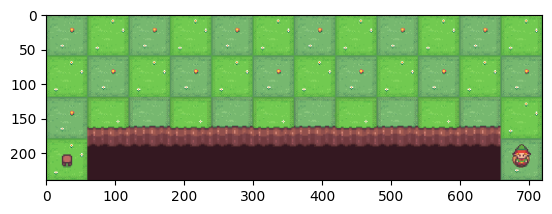

In [ ]:
# extract the policy from the Q-function
policy = lambda s: np.argmax(qlearning_Q[s])
run_env_w_policy(cliffwalking.rendered_env, policy, steps=50)

## 3.3 SARSA (On-policy TD control)

$$Q(s, a) \leftarrow Q(s, a) + α * (r + γ * Q(s', a') - Q(s, a))$$

Where:
- Q(s, a): the current Q-value for state 's' and action 'a'
- α: the learning rate (0 <= α <= 1)
- r: the immediate reward for taking action 'a' in state 's'
- γ: the discount factor (0 <= γ <= 1)
- Q(s', a'): the Q-value for the next state 's' and the next action 'a'


🛑 <mark>TODO:</mark>
In the following section, you are required to implement SARSA

In [ ]:
# Hint: RL Sutton book, 6.4
def SARSA(env_obj, num_episodes, episode_length=100, discount_factor=1.0, epsilon=0.1, seed=SEED, alpha=0.5, verbose=True):
    """
    > For each episode, we run a loop for a maximum of `episode_length` steps. In each step, we take an
    action according to the epsilon-greedy policy, observe the reward and next state, and update the
    Q-value of the state-action pair

    :param env_obj: The environment object that include a gym environment to run the algorithm on
    :param num_episodes: the number of episodes to run the algorithm for
    :param episode_length: The maximum length of an episode, defaults to 100 (optional)
    :param discount_factor: the discount factor for the MDP (optional)
    :param epsilon: the probability of choosing a random action (optional)
    :param seed: The random seed to use for the environment     (optional)
    :param alpha: the learning rate (optional)
    :param verbose: If True, it will print the progress of the algorithm each specific frequency, defaults to True (optional)
    :return:
        * Q-function: a dictionary, such that the key is (state, action) and the value is the action-state-value
        * policy: an epsilon greedy policy used during the training based on the computed Q-table
        * stats: a dictionary, such that it has two keys rew & len, and the values are the total reward and length of the episode, respectively.
    """
    env = env_obj.env
    logging_freq = int(num_episodes*0.1)
    fix_seed(env, seed)
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # Store the reward and length of episodes during the running of the method
    stats = defaultdict(list)

    ######## TODO ########
    # Note (Important):
    cur_epinum = 0
    policy = partial(epsilon_greedy_policy_fn, Q=Q, epsilon=epsilon, env=env)
    while(cur_epinum <= num_episodes):
      cur_epinum = cur_epinum + 1
      cur_epi = rollout(policy, env, episode_length)
      epi_len = compute_episode_length(cur_epi)
      ret = compute_episode_return(cur_epi, discount_factor)
      stats["rew"].append(ret)
      stats["len"].append(epi_len)
      for i in range(epi_len-1):
        st = cur_epi[i][0]
        act = cur_epi[i][1]
        reward = cur_epi[i][2]
        st1 = cur_epi[i+1][0]
        act1 = cur_epi[i+1][1]
        Q[st][act] = Q[st][act] + alpha*(reward + discount_factor*Q[st1][act1] - Q[st][act])
      if verbose and (cur_epinum)%logging_freq == 0:
        env_obj.plot_Vfunction_from_Q(Q)
    # For each episode, make sure that you call:
    # * stats["rew"].append(cumulative_reward)
    # * stats["len"].append(episode_length)
    # Such that cumulative_reward is the total reward in the episode
    #  and episode_length stores the length of the episode
    # * if verbose and (episode_idx+1)%logging_freq == 0:
    #       env_obj.plot_Vfunction_from_Q(Q)

    # Hint: you can use: policy = partial(epsilon_greedy_policy_fn, Q=Q, epsilon=epsilon, env=env)

    # Hint: Q dictionary has the following form to access its values: Q[state][action]


    ######################
    return Q, policy, stats

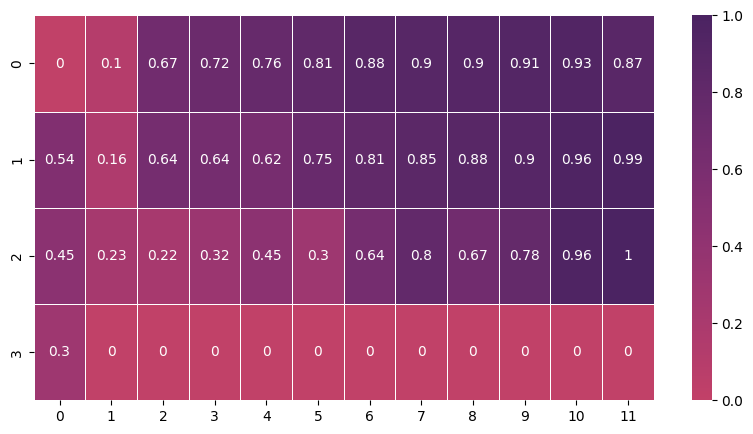

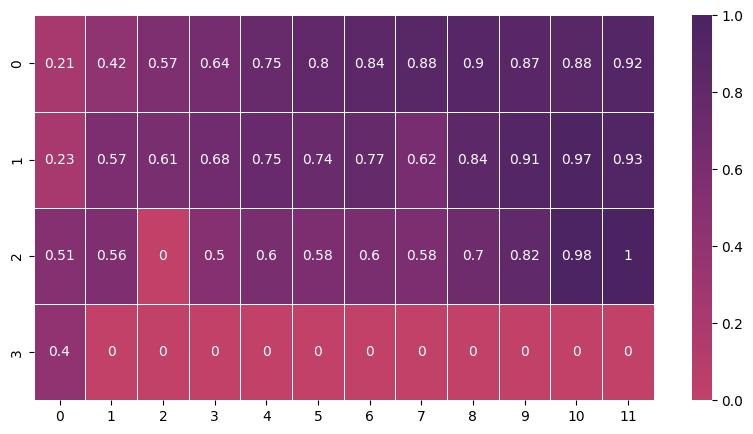

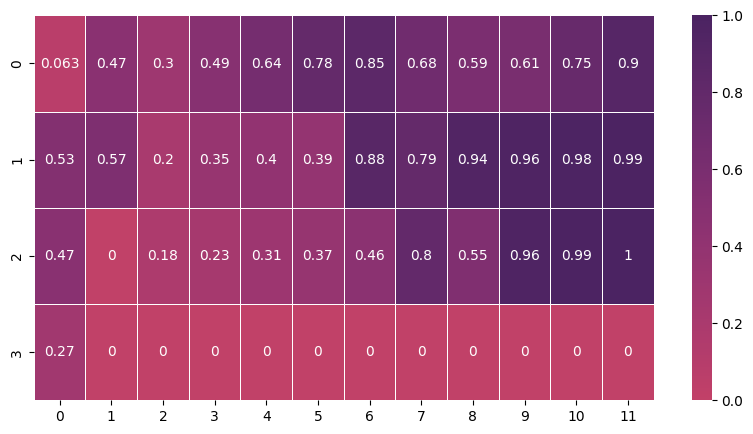

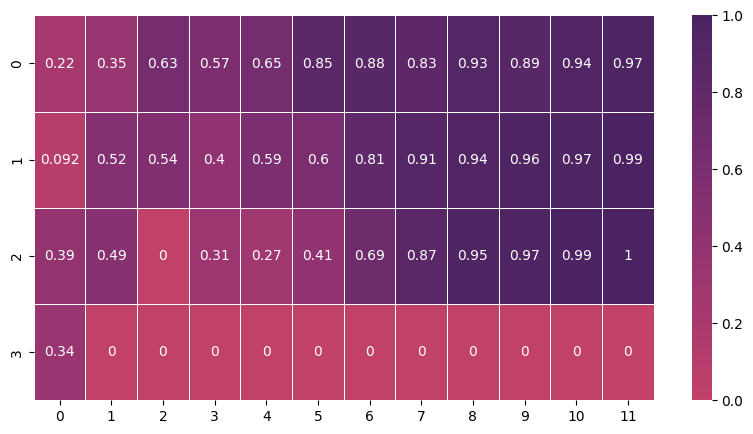

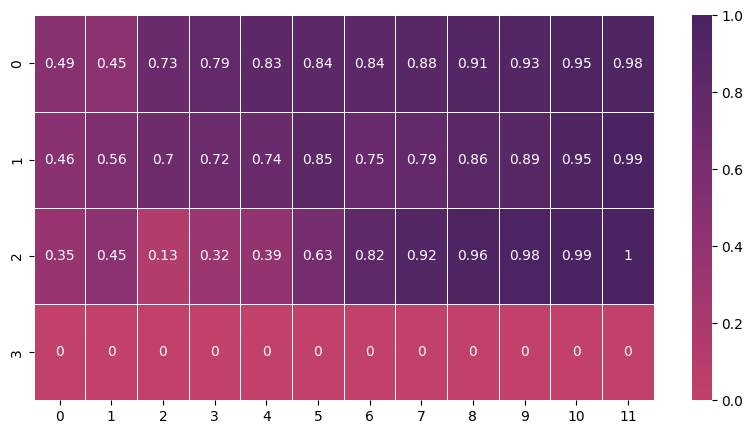

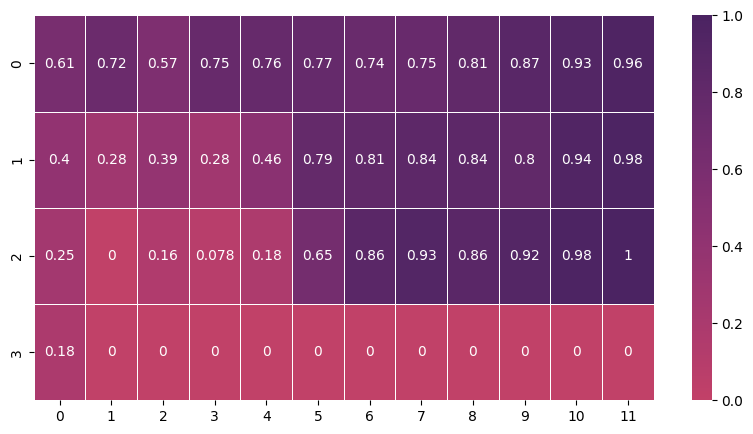

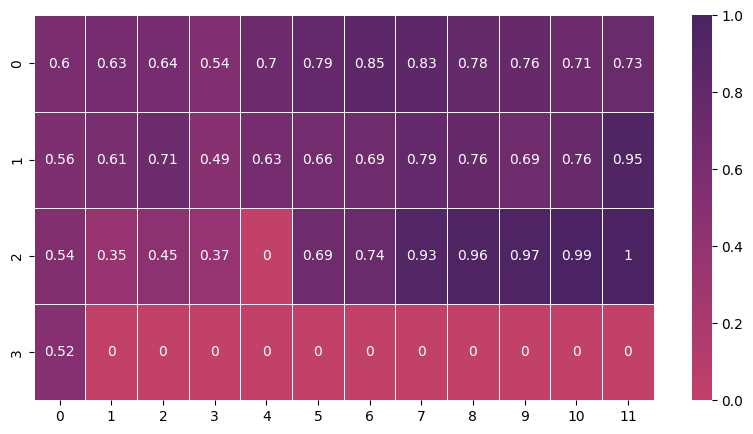

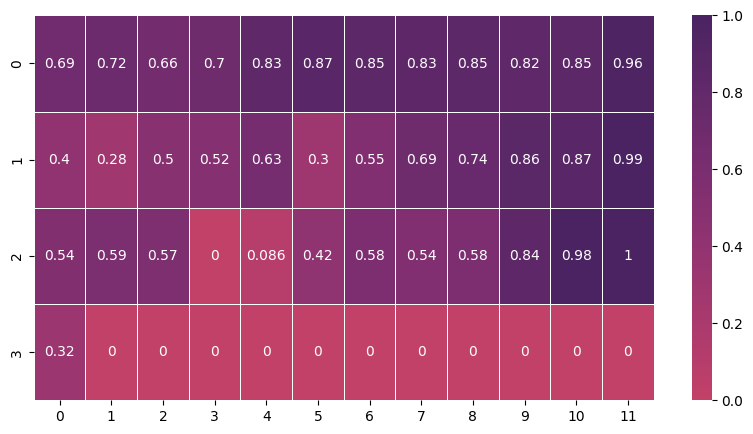

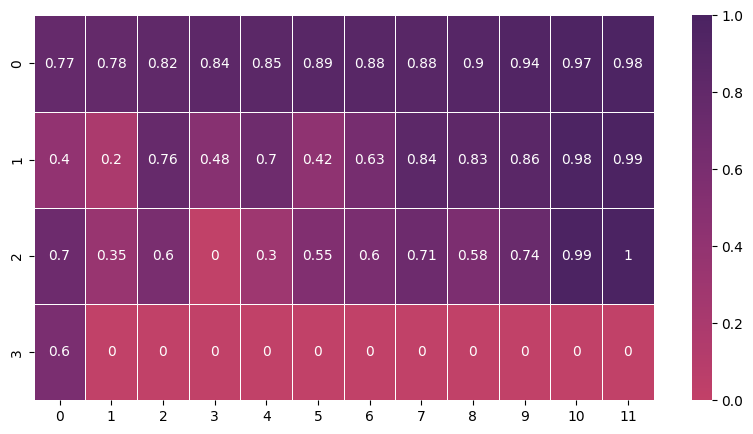

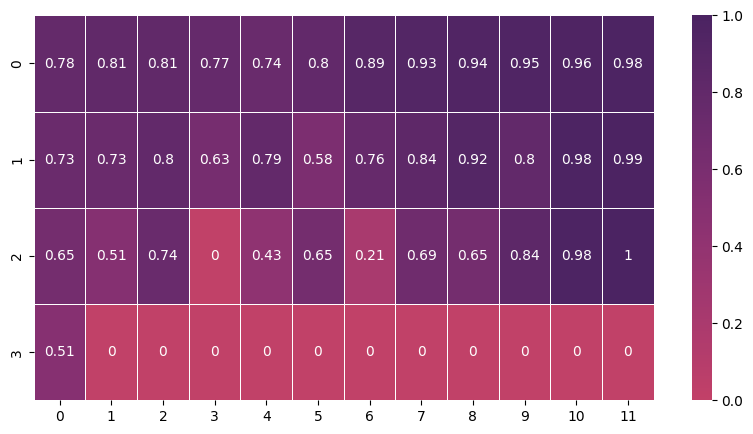

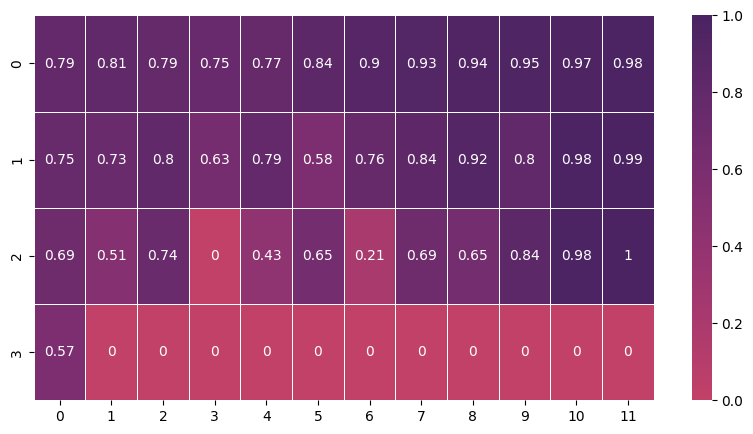

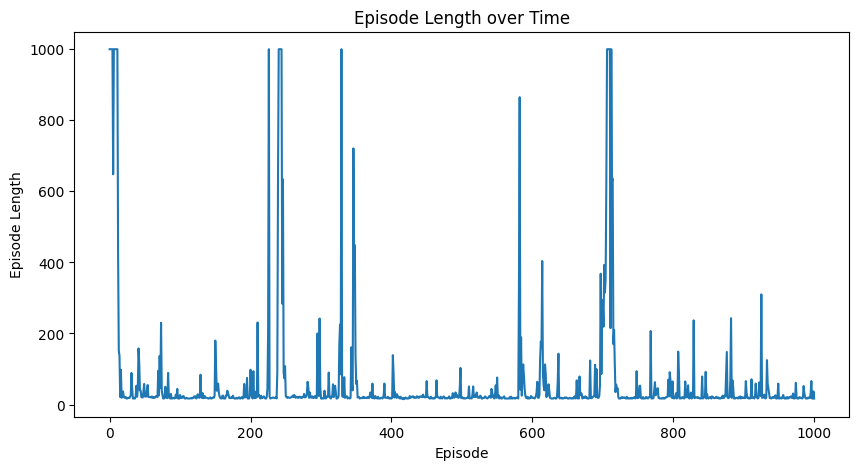

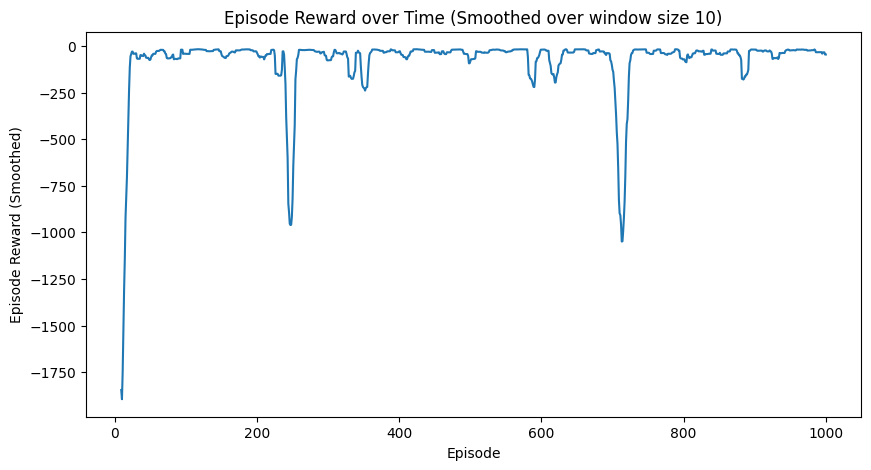

(<Figure size 1000x500 with 1 Axes>, <Figure size 1000x500 with 1 Axes>)

In [ ]:
env_obj = cliffwalking
sarsa_Q, policy, stats = SARSA(env_obj, num_episodes=1000, episode_length=1000)
env_obj.plot_Vfunction_from_Q(sarsa_Q)
env_obj.plot_episode_stats(stats)

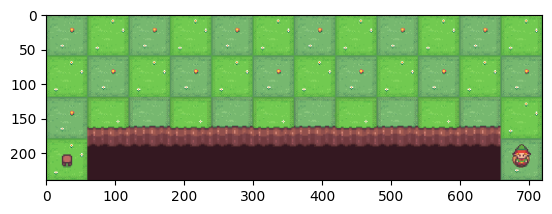

In [ ]:
# extract the policy from the Q-function
policy = lambda s: np.argmax(sarsa_Q[s])
run_env_w_policy(env_obj.rendered_env, policy, steps=50)

🛑 <mark>TODO:</mark>

For CliffWalking environment, do the following:

- Plot the state-value function using a random policy
- Plot the state-value function using the trained policy by Q-Learning
- Plot the state-value function using the trained policy by SARSA

Then answer the questions stated in the following todo.

Hint: You may try to estimate the policy using MC or TD0 and discuss the observed results, you may change the number of episodes for different state-value function predictions. (You may add extra cells if it is necessary for your analysis)

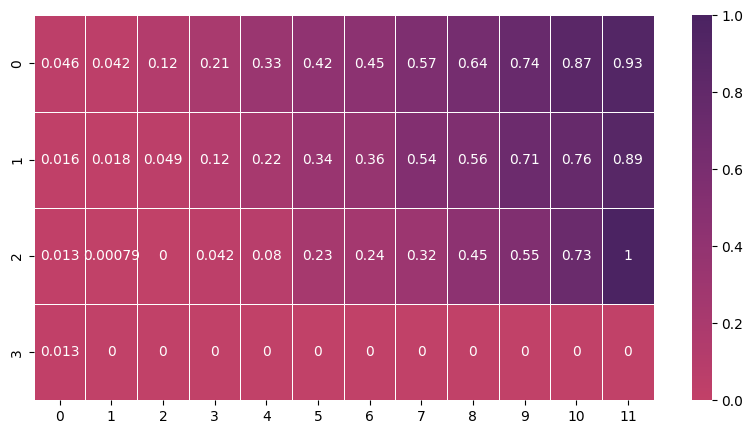

In [ ]:
######## TODO ########
# Plot the state-value fucntion using a random policy
V = mc_prediciton_first_visit(cliffwalking.get_random_policy(), cliffwalking, num_episodes=1000)
cliffwalking.plot_Vfunction(V)
######################

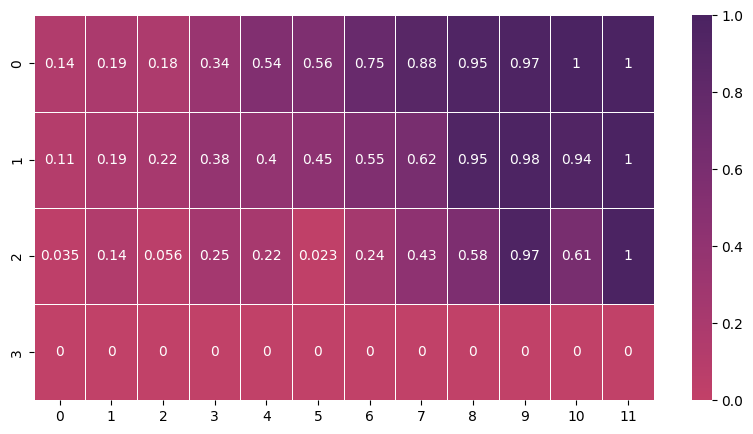

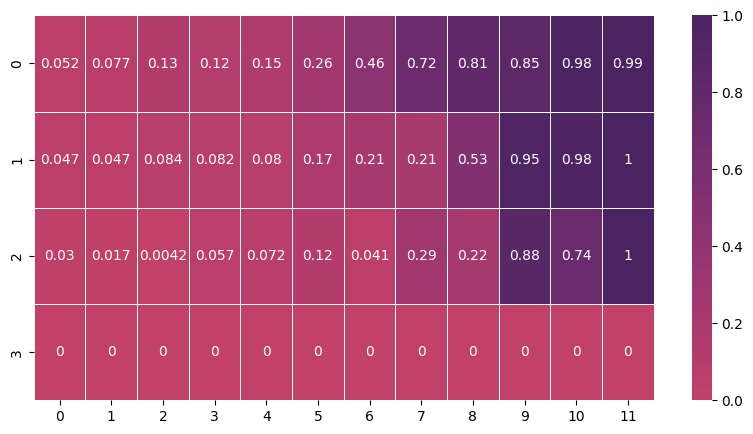

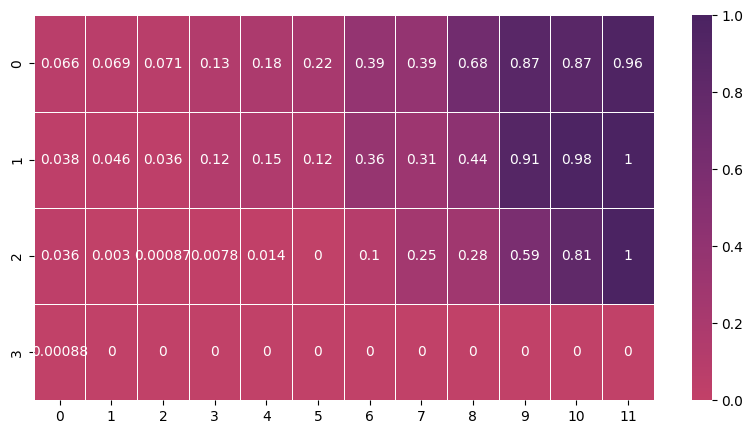

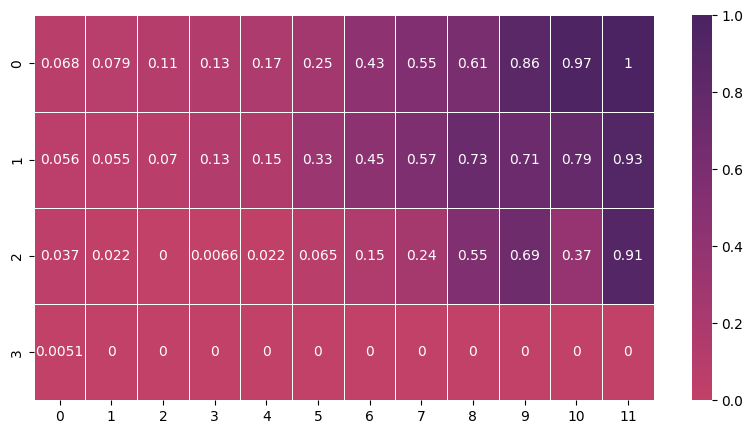

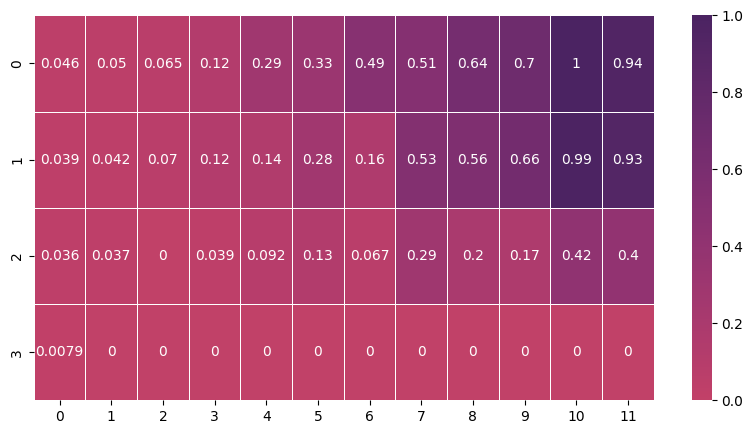

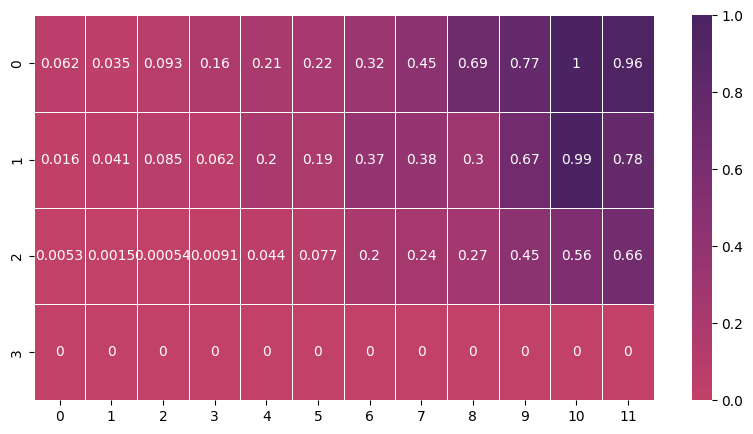

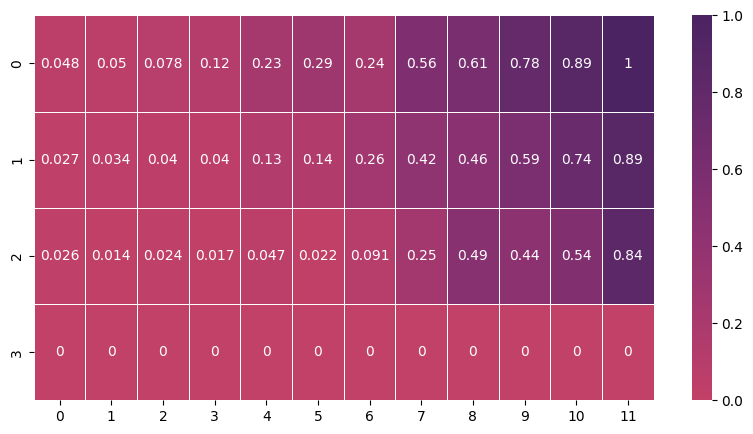

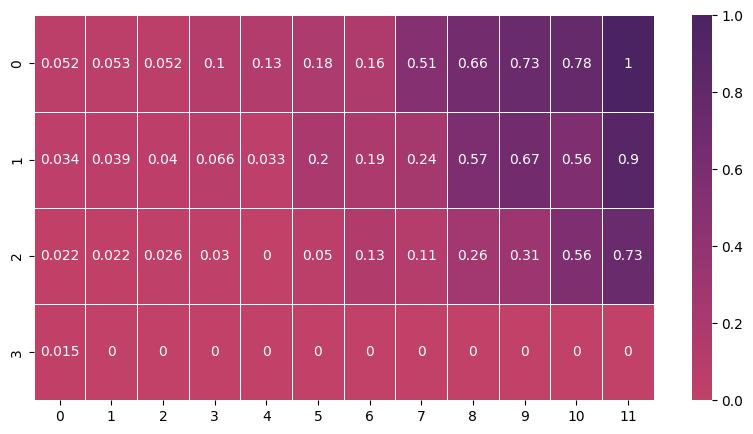

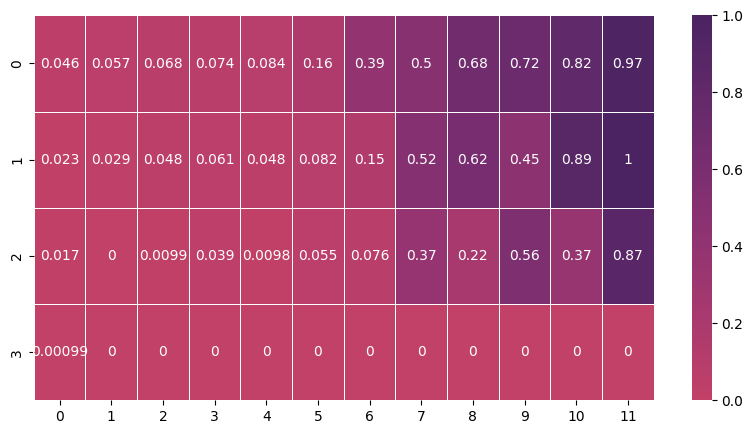

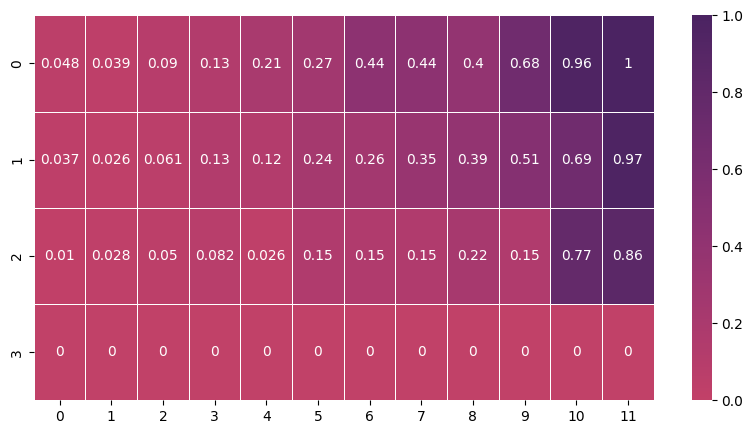

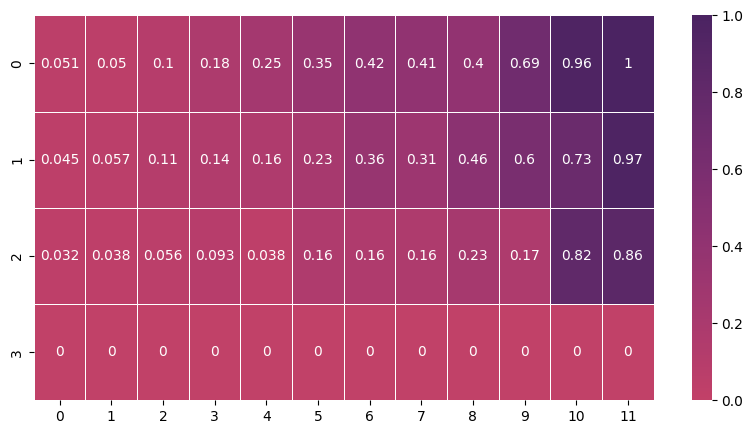

In [ ]:
######## TODO ########
# Plot the state-value fucntion using a random policy
V = TD0(cliffwalking.get_random_policy(), cliffwalking, num_episodes=1000)
cliffwalking.plot_Vfunction(V)
######################

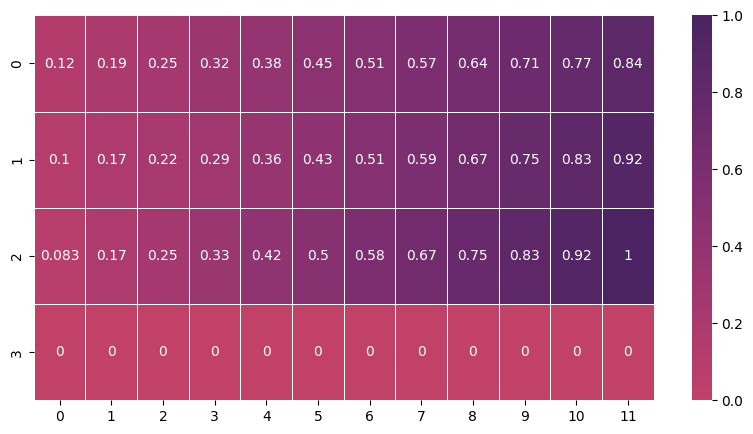

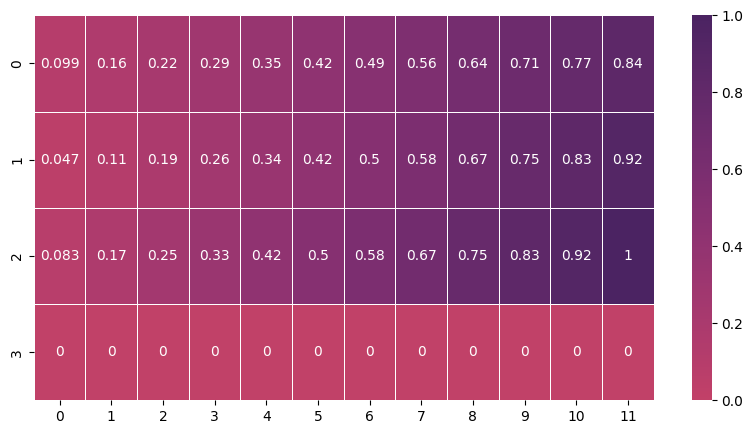

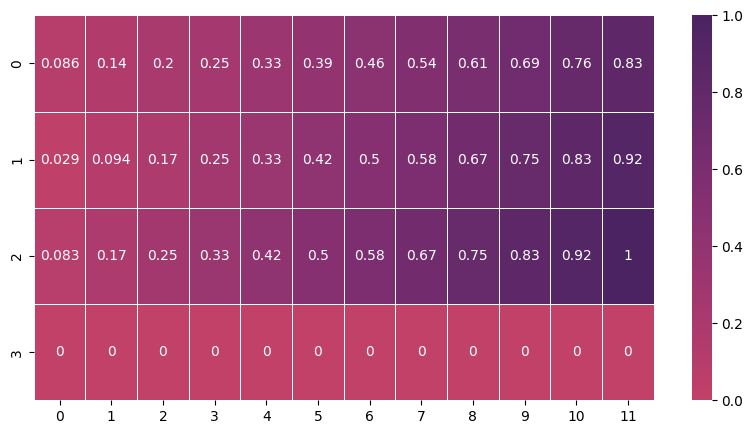

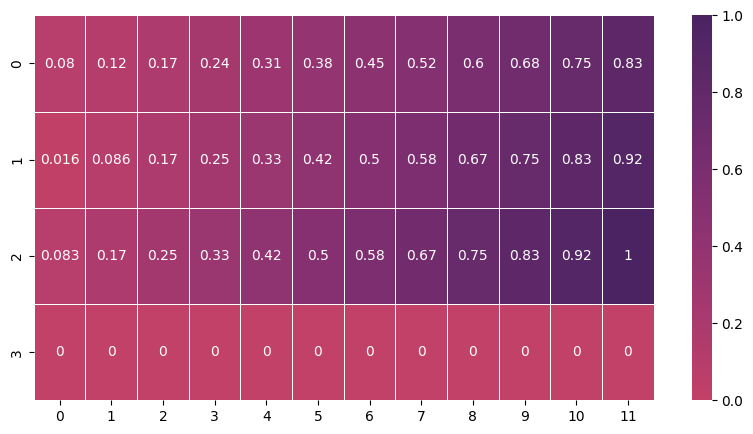

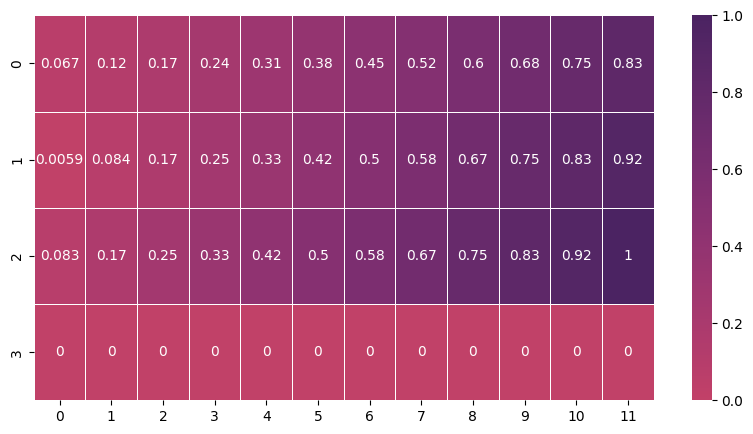

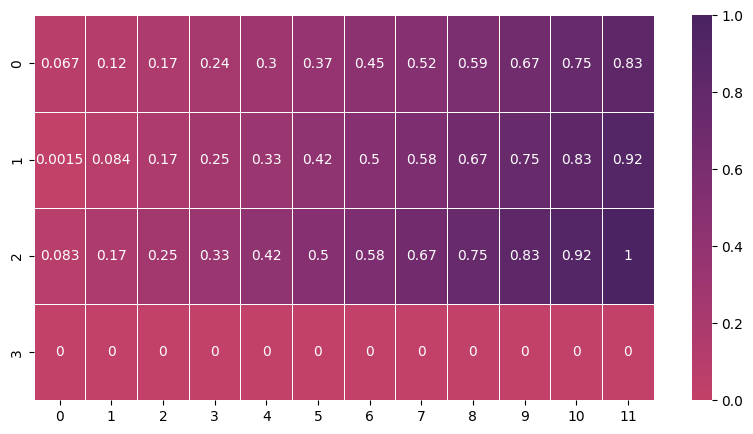

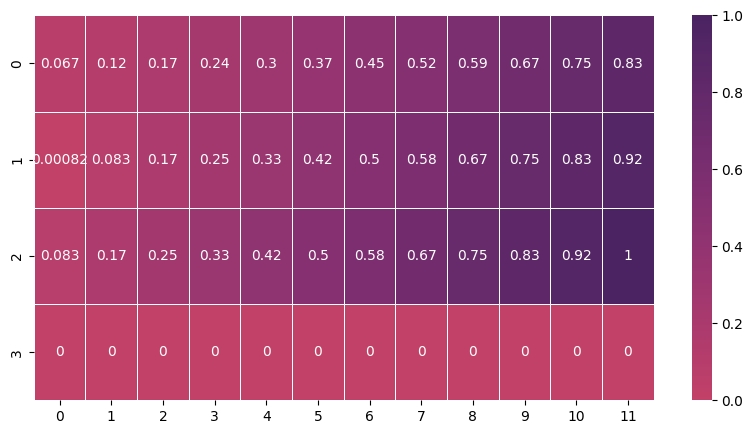

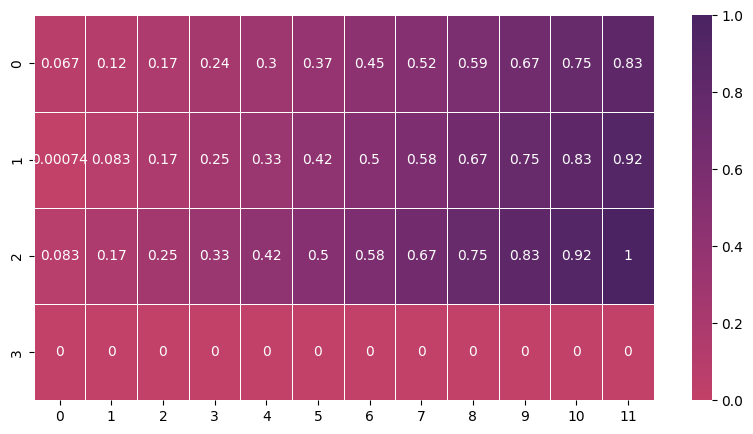

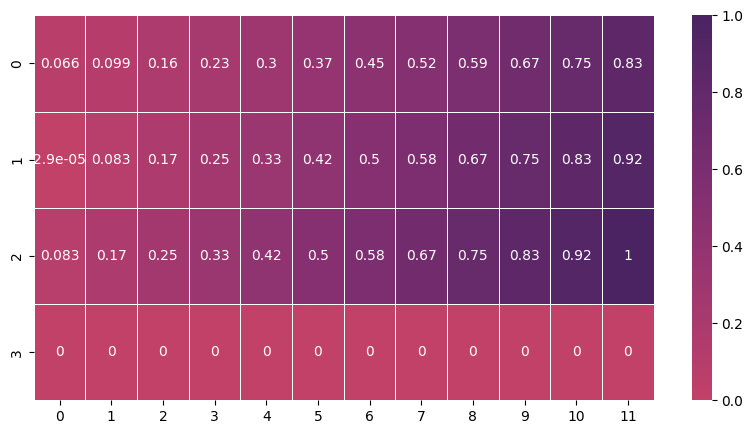

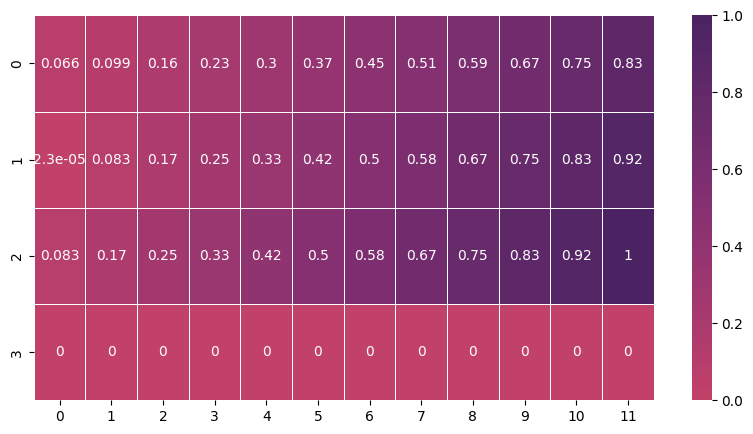

the state-value function from learned policy


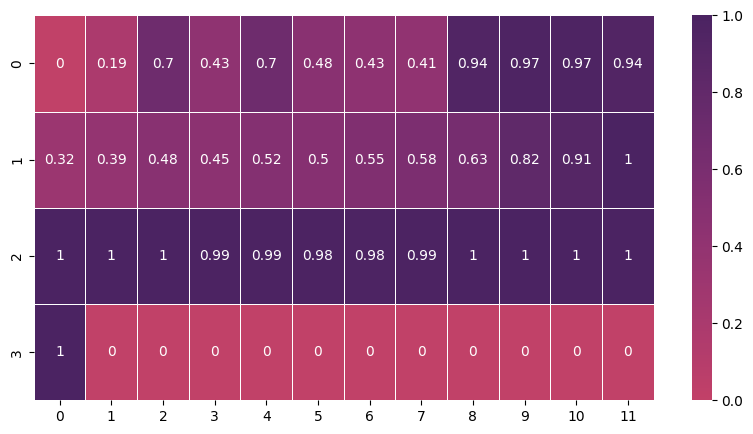

In [ ]:
######## TODO ########
# Plot the state-value fucntion using the learnt policy from Q-Learning
qlearning_Q, policy, stats = QLearning(cliffwalking, num_episodes=1000, episode_length=1000)
print("the state-value function from learned policy")
V = mc_prediciton_first_visit(policy, cliffwalking, num_episodes=3000)
cliffwalking.plot_Vfunction(V)
######################

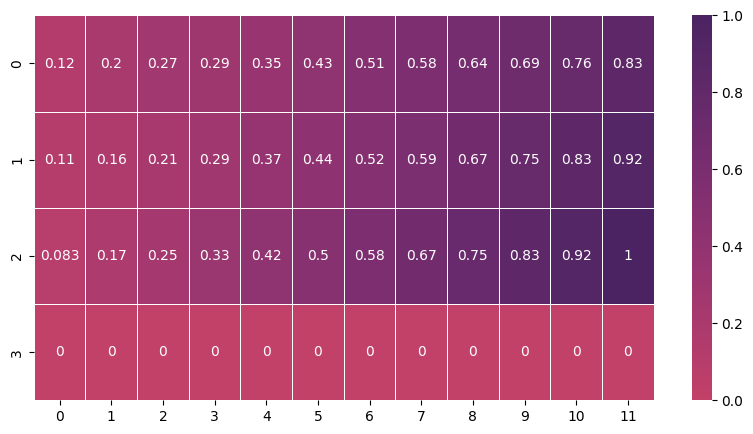

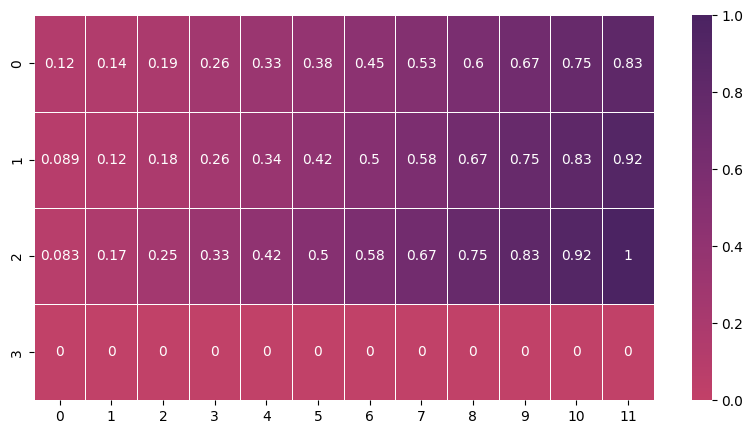

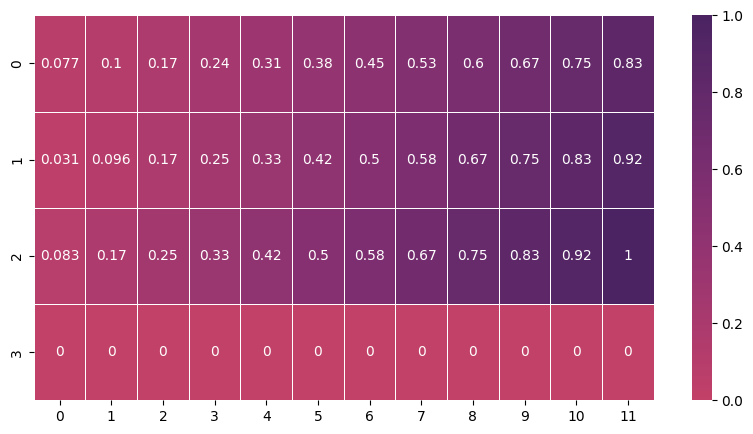

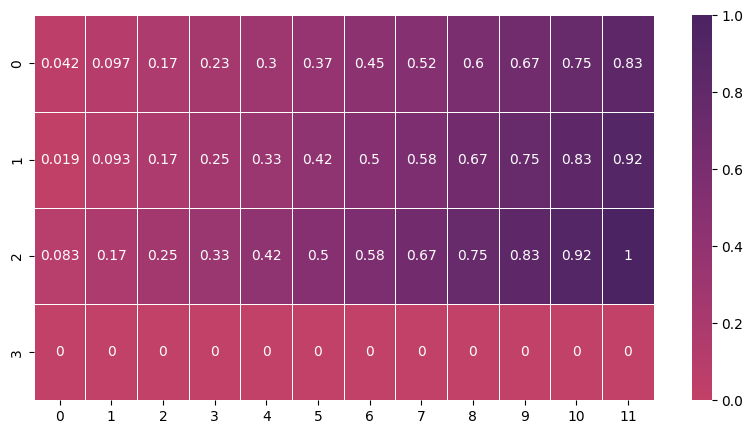

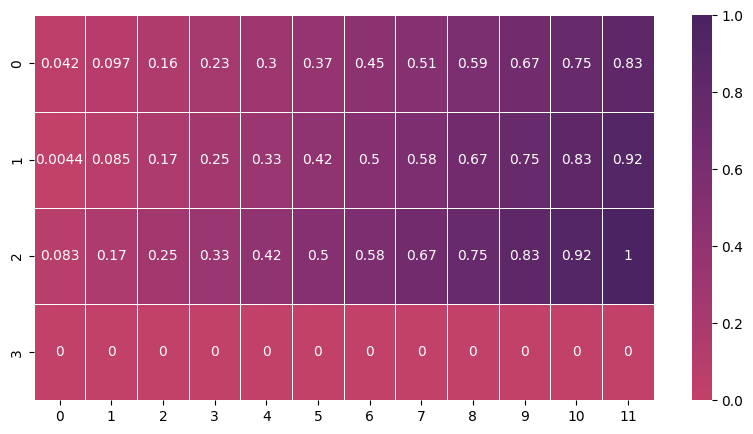

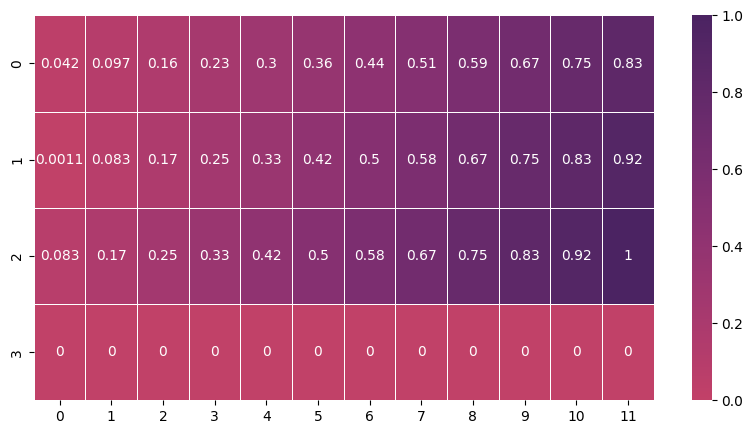

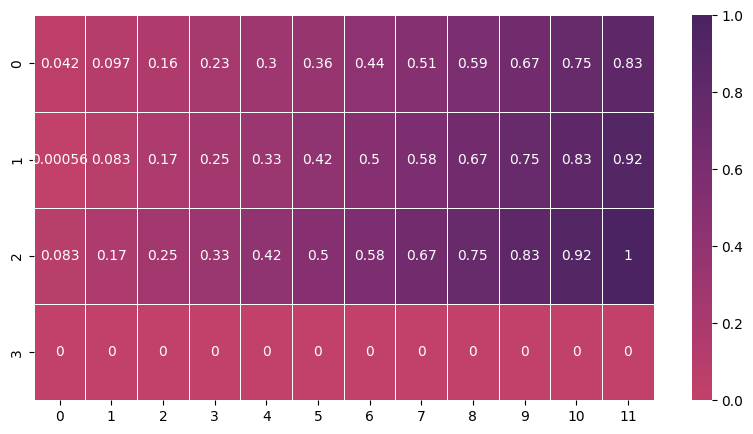

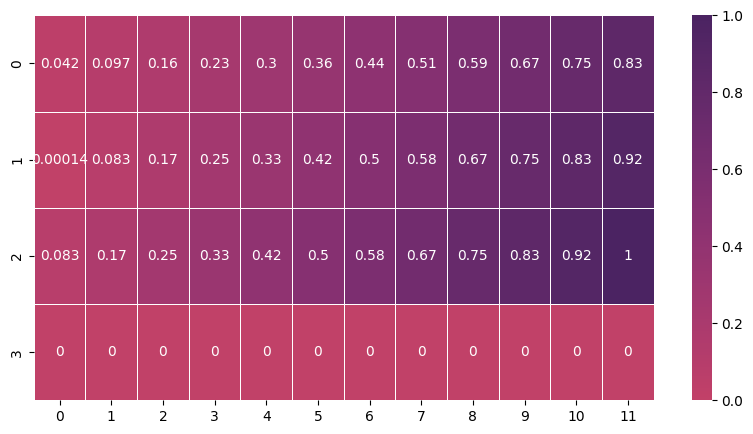

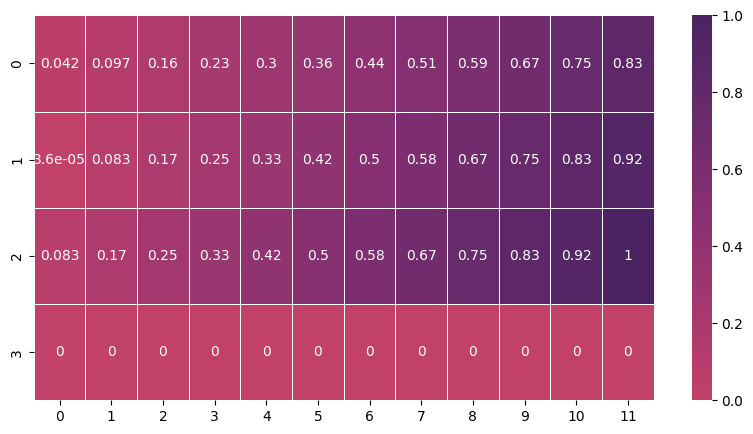

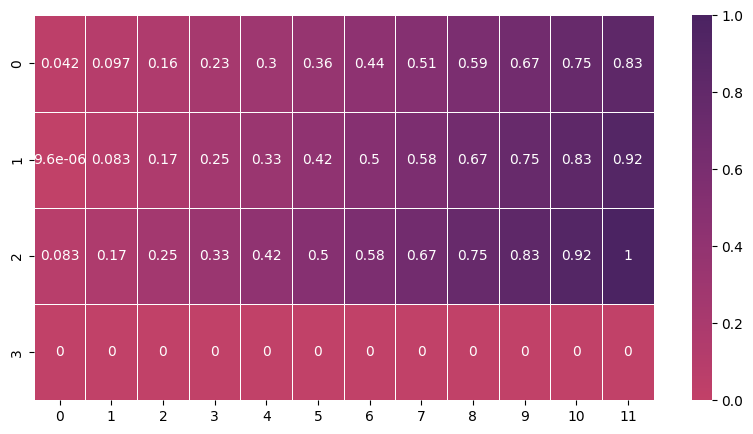

the state-value function from learned policy


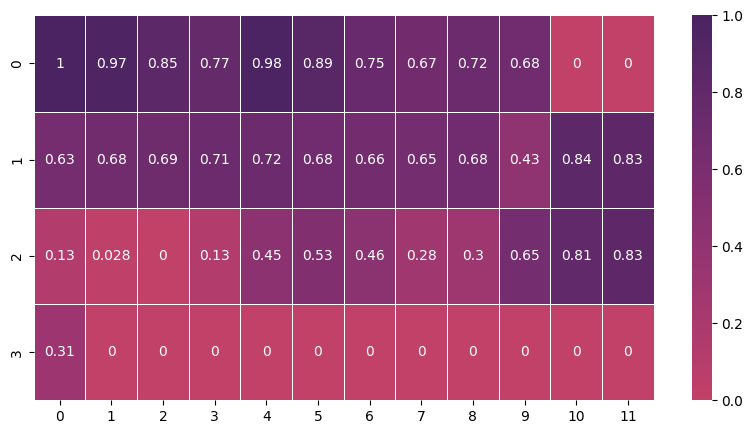

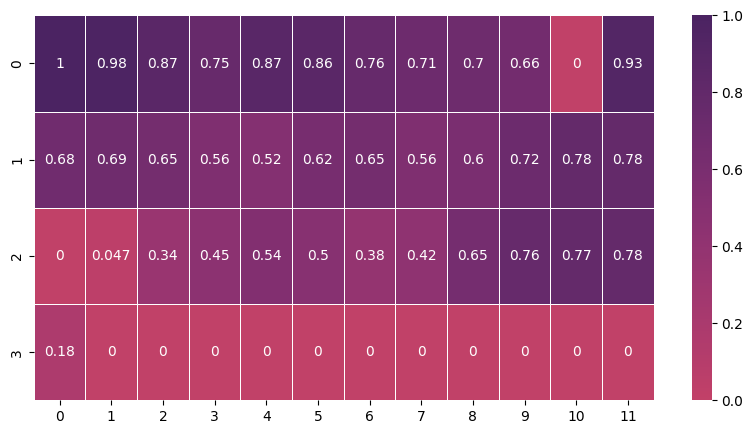

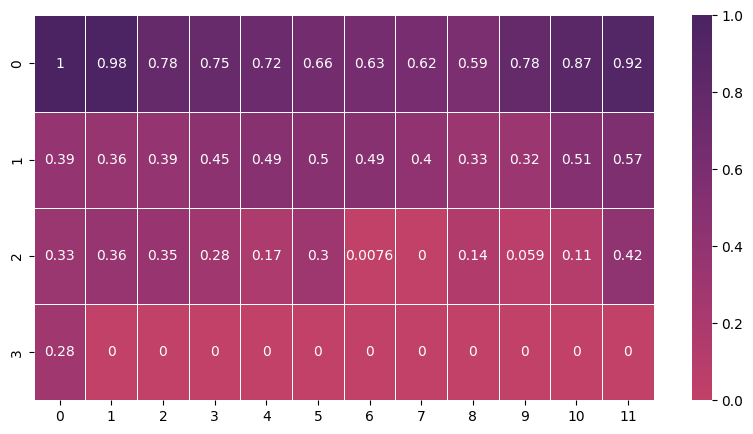

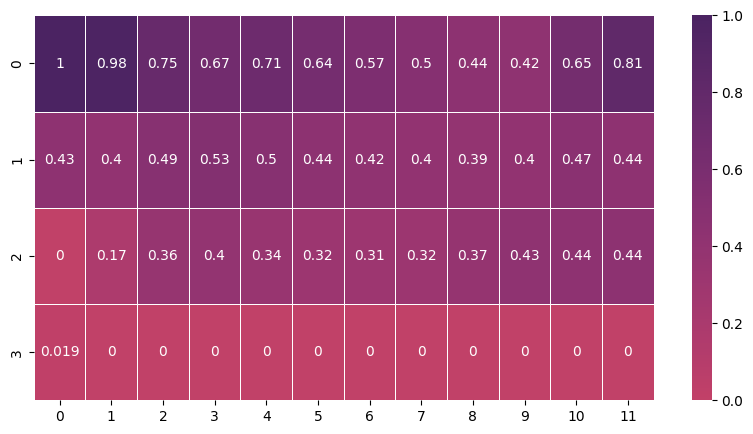

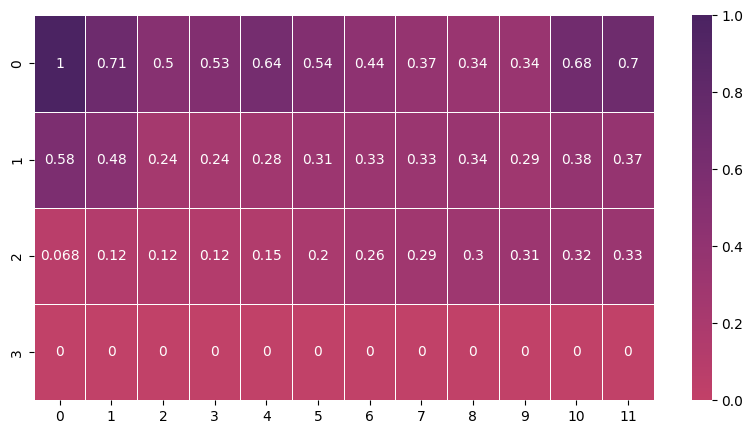

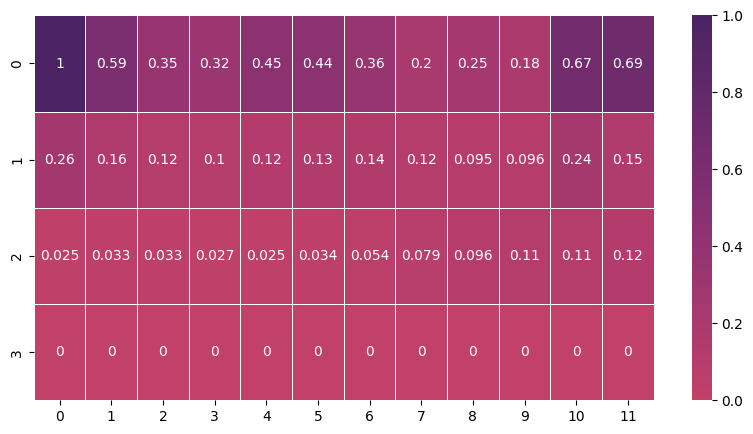

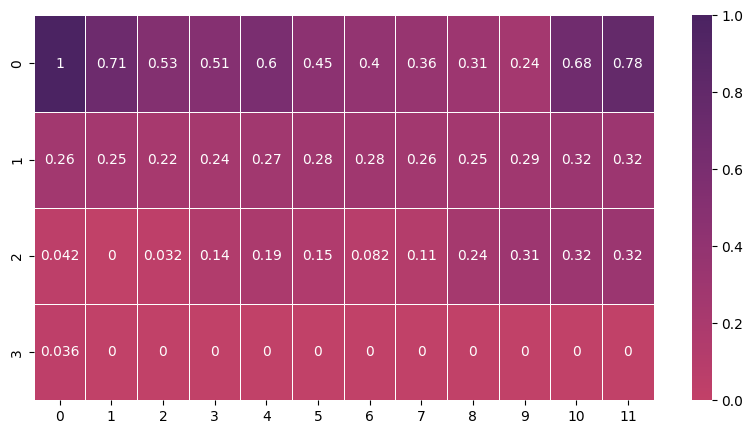

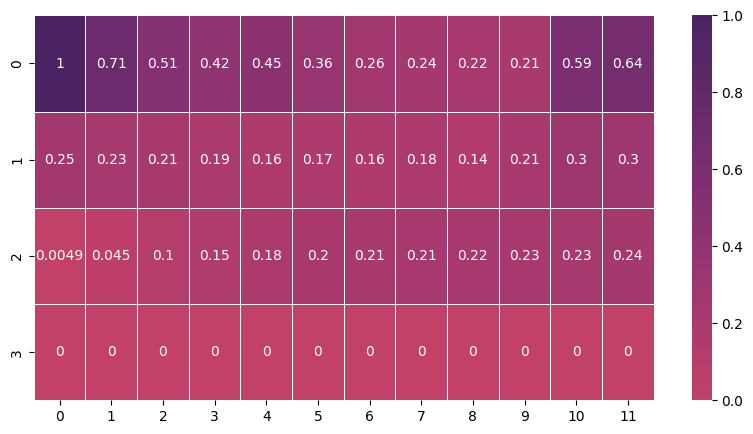

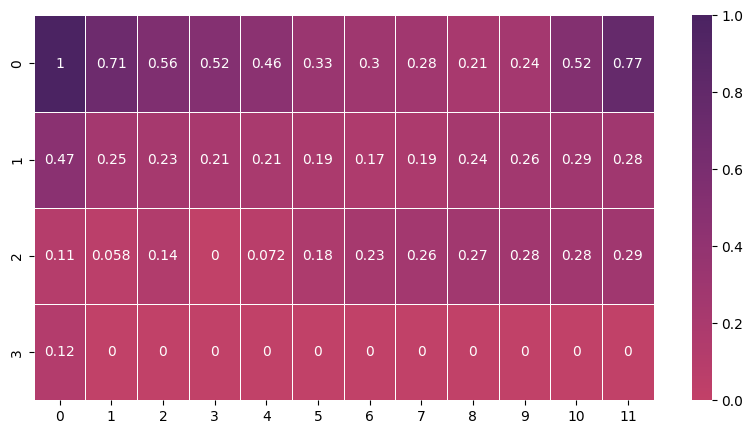

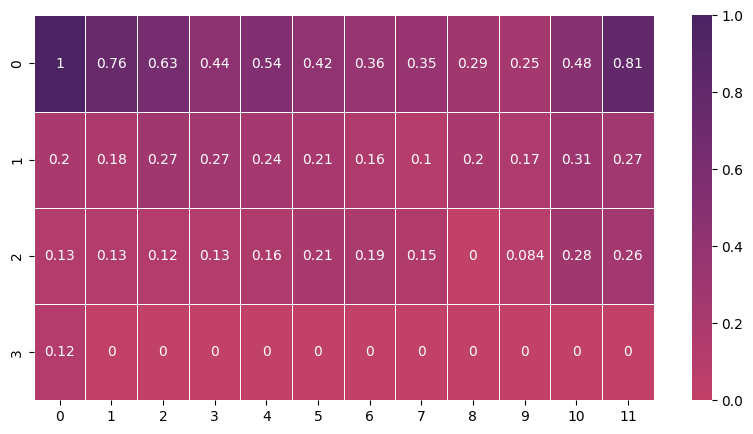

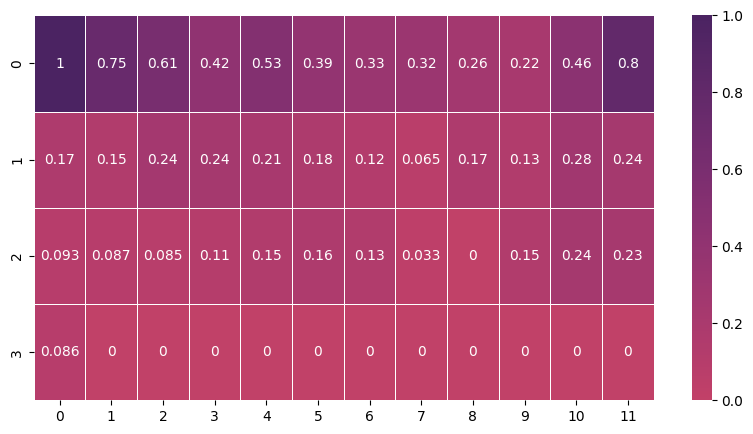

In [ ]:
######## TODO ########
# Plot the state-value fucntion using the learnt policy from Q-Learning
qlearning_Q, policy, stats = QLearning(cliffwalking, num_episodes=1000, episode_length=1000)
print("the state-value function from learned policy")
V = TD0(policy, cliffwalking, num_episodes=3000)
cliffwalking.plot_Vfunction(V)
######################

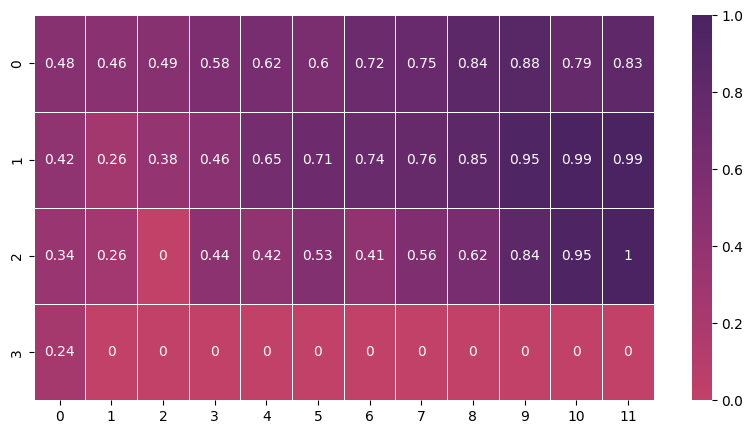

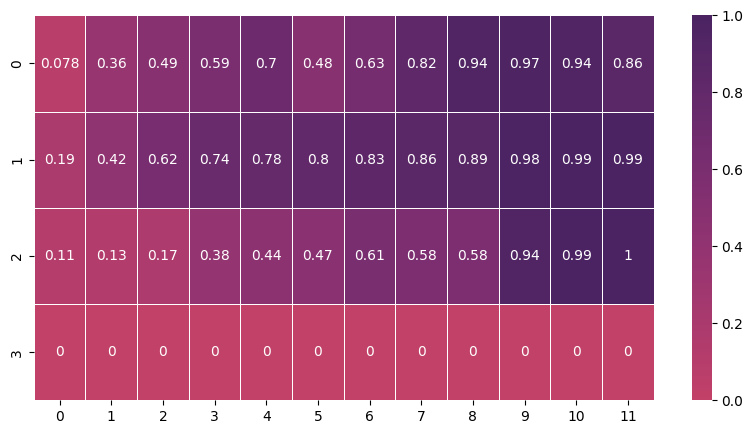

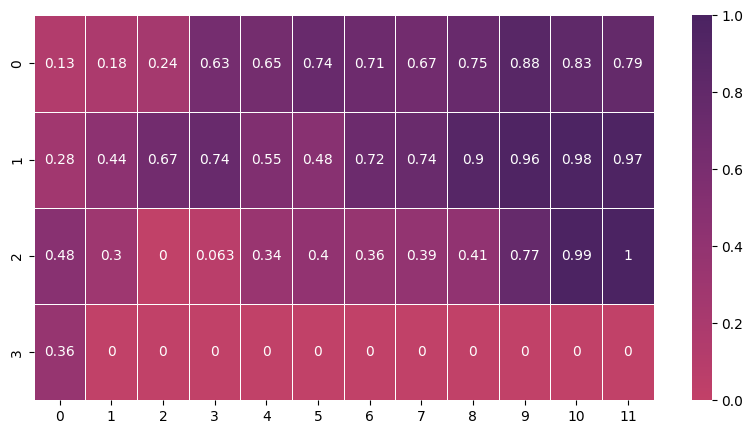

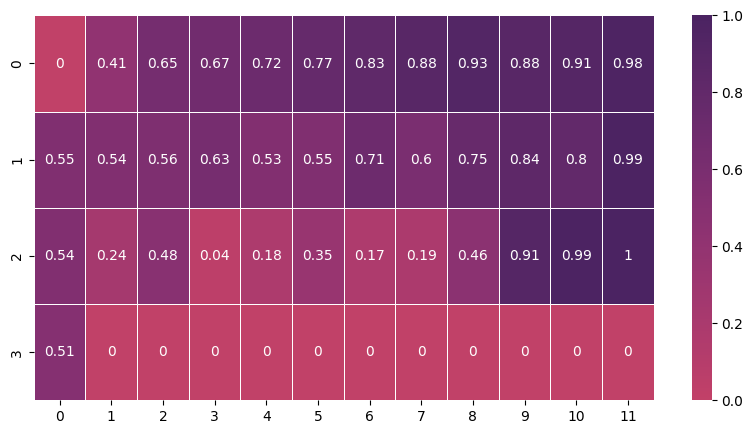

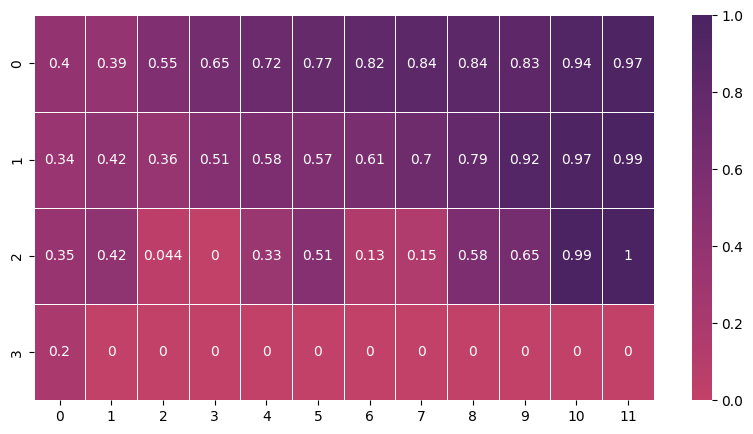

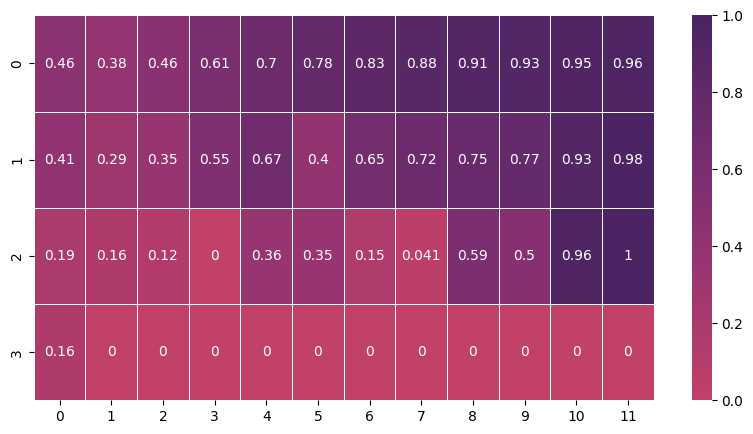

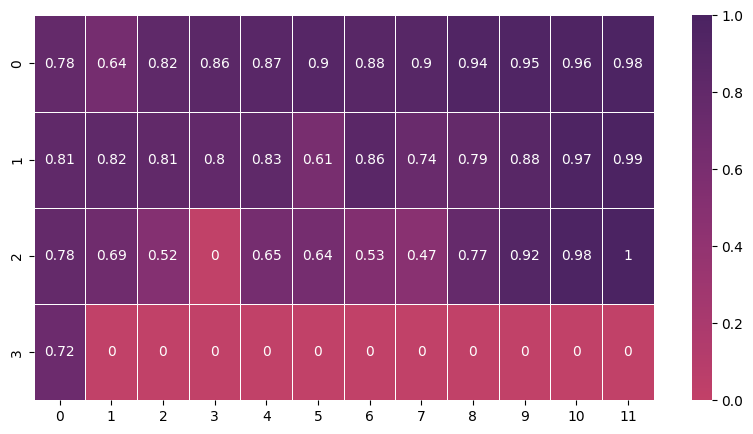

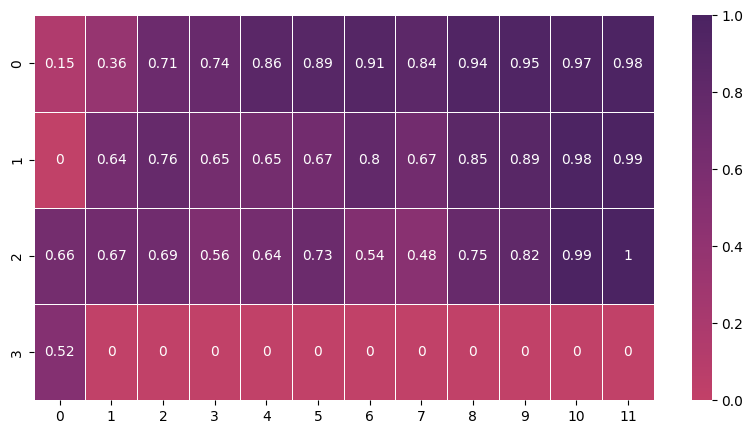

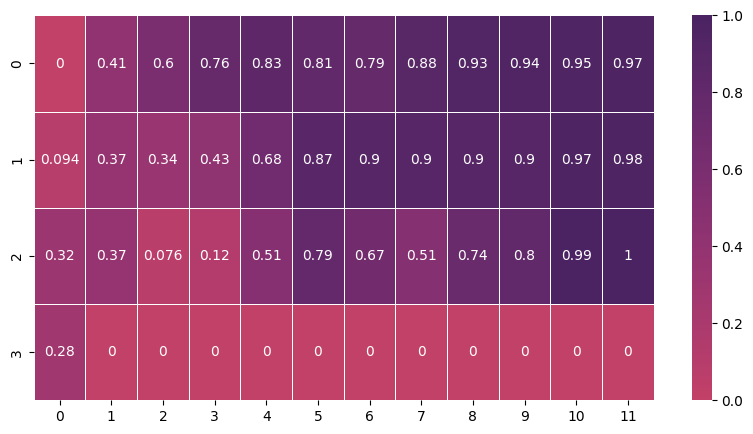

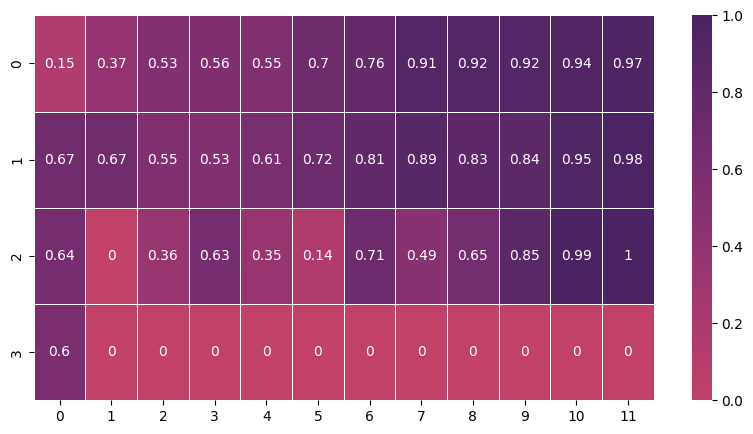

the state-value function from learned policy


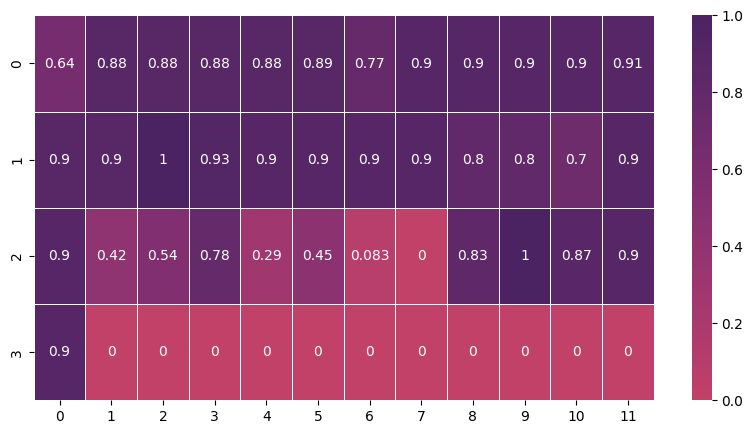

In [ ]:
######## TODO ########
# Plot the state-value fucntion using the learnt policy from SARSA
sarsa_Q, policy, stats = SARSA(cliffwalking, num_episodes=1000, episode_length=1000)
print("the state-value function from learned policy")
V = mc_prediciton_first_visit(policy, cliffwalking, num_episodes=3000)
cliffwalking.plot_Vfunction(V)
######################

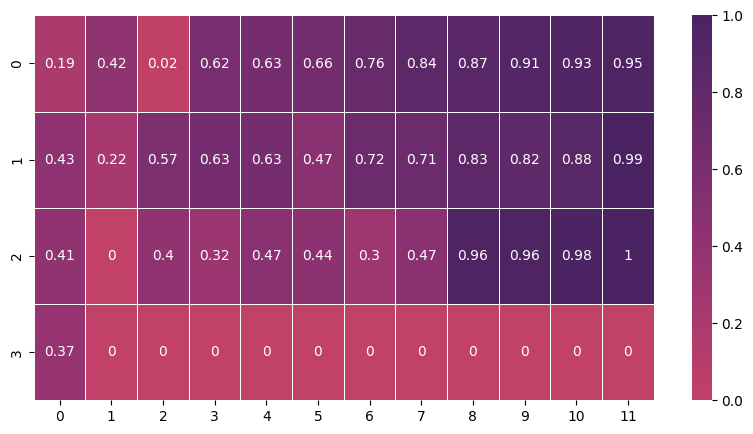

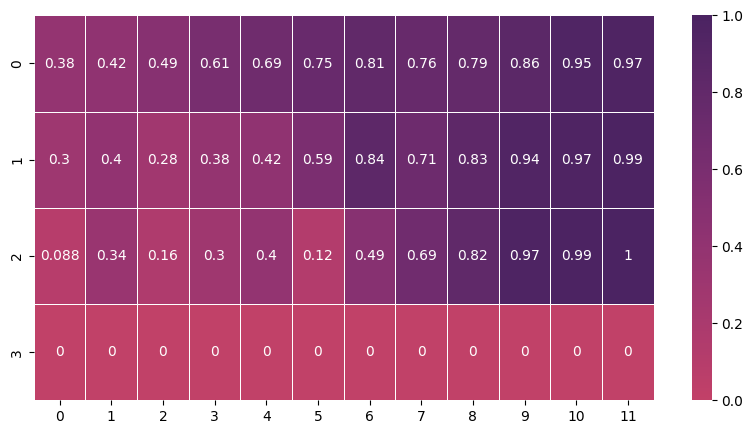

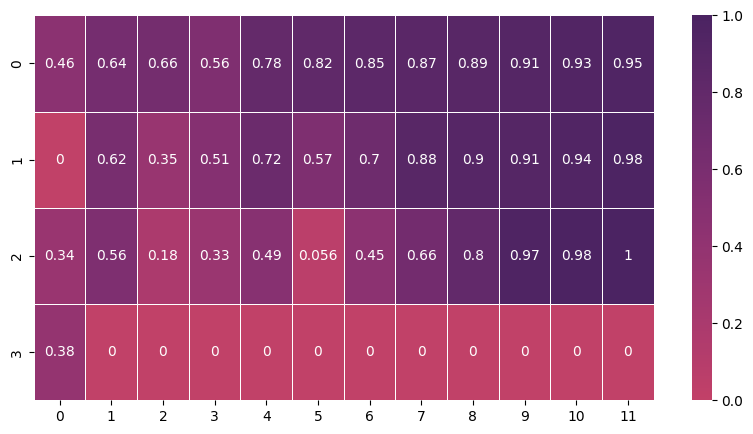

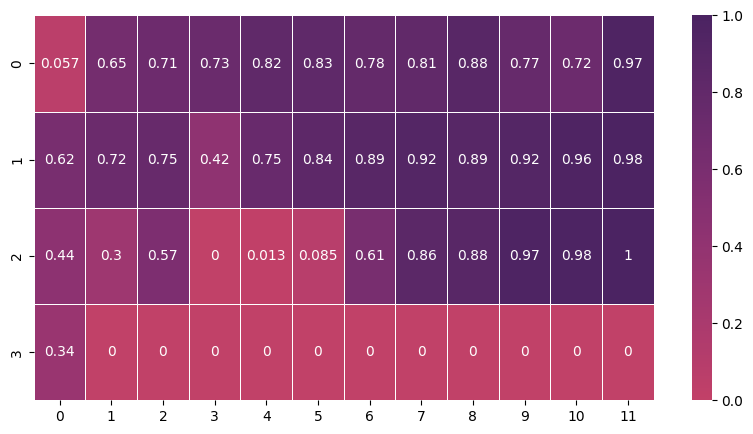

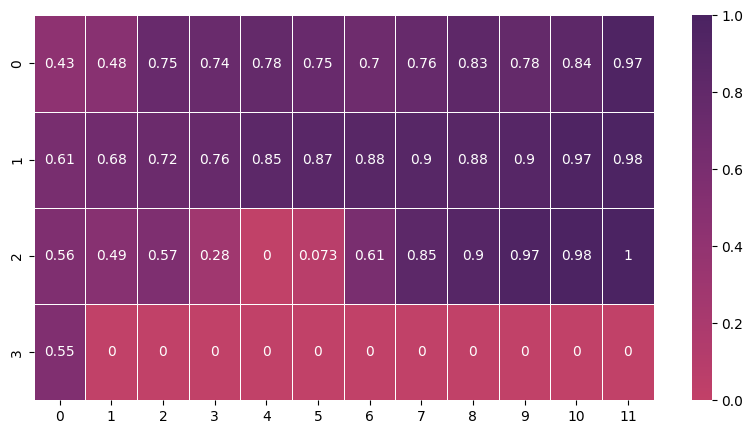

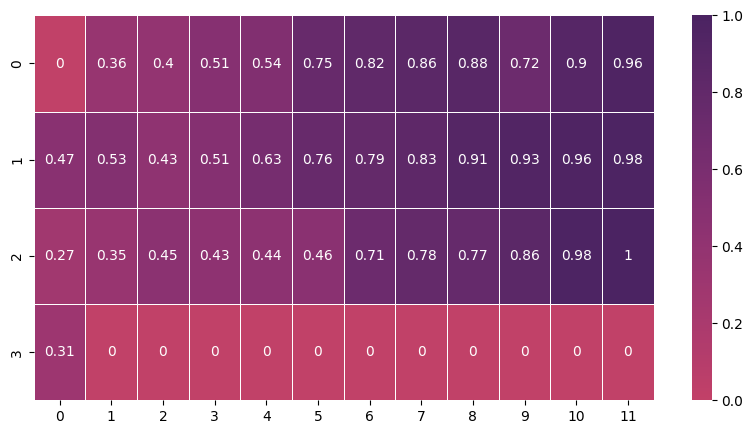

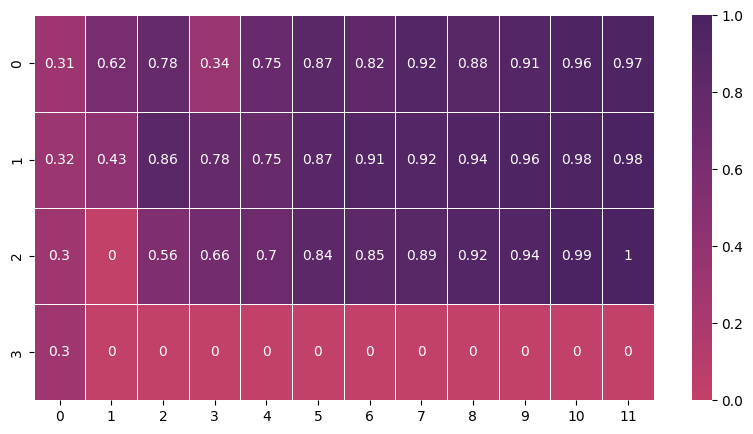

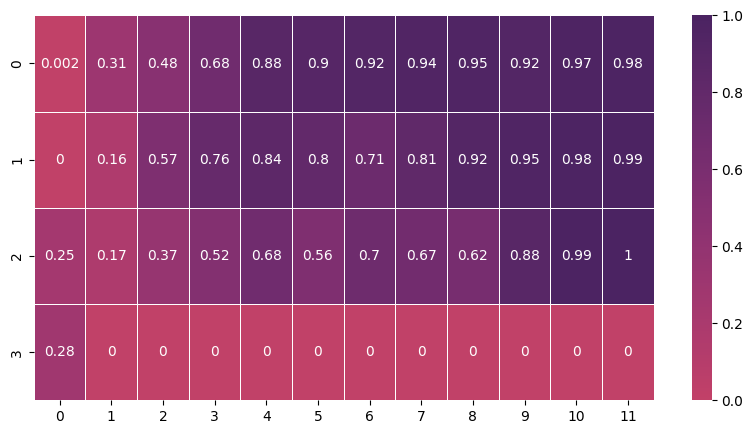

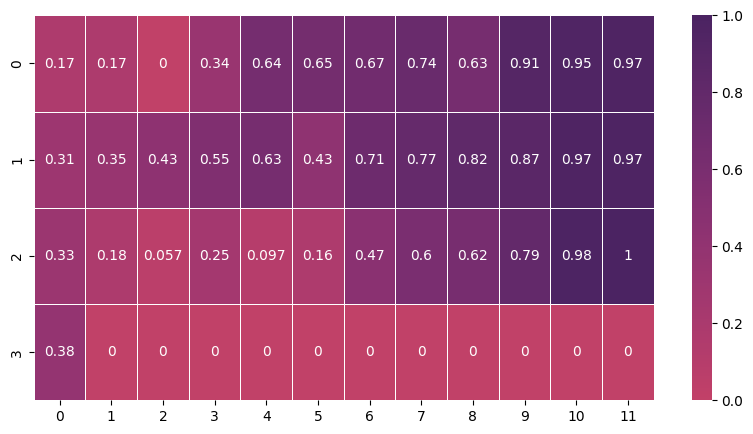

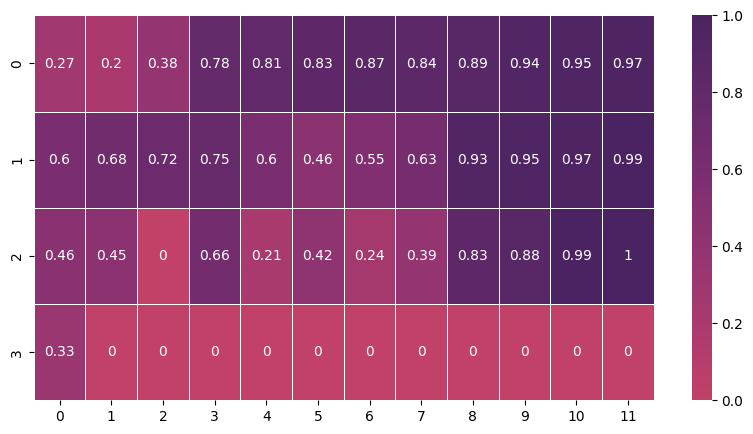

the state-value function from learned policy


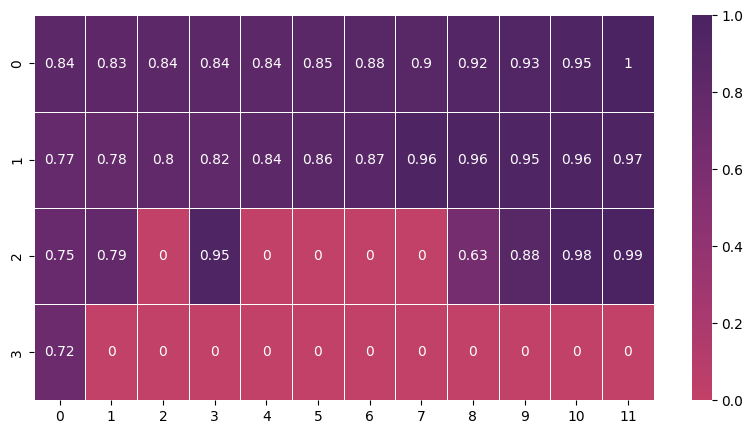

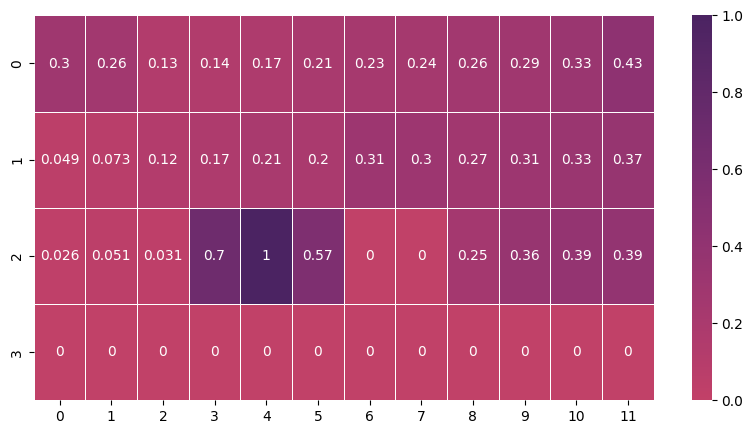

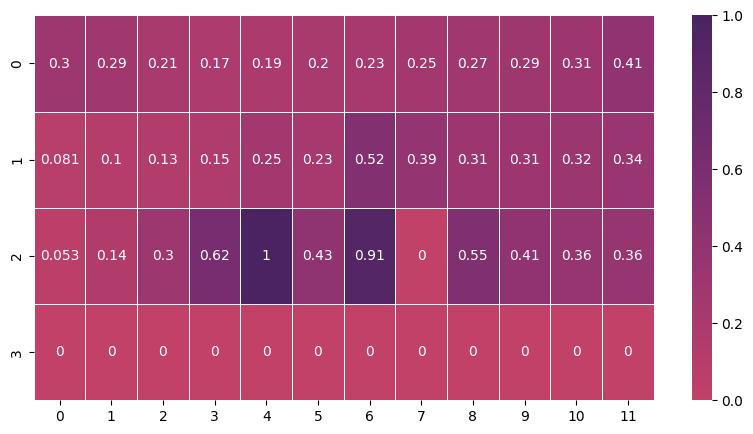

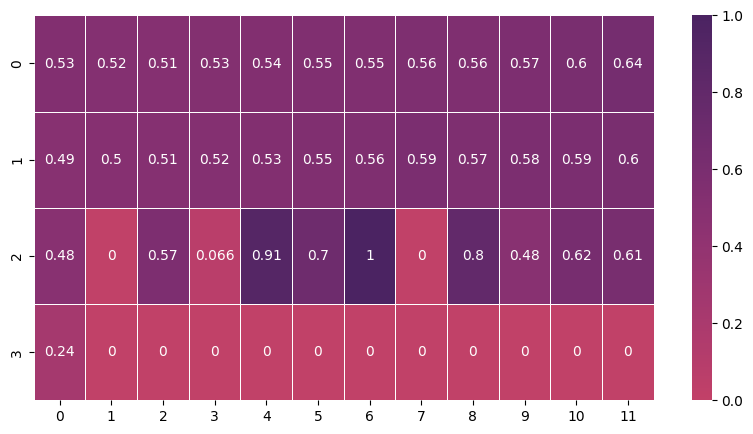

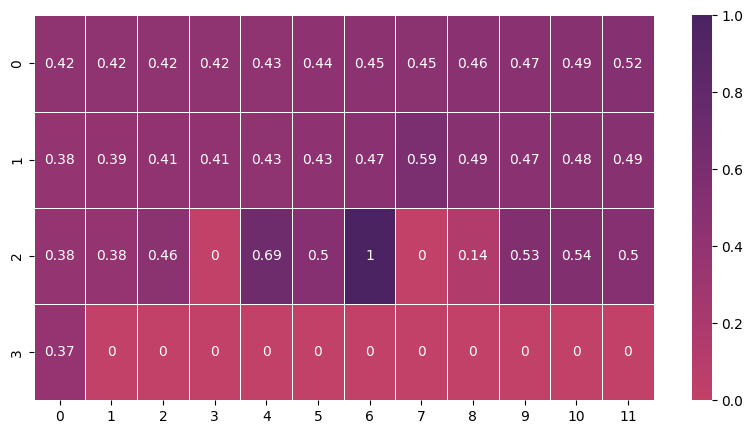

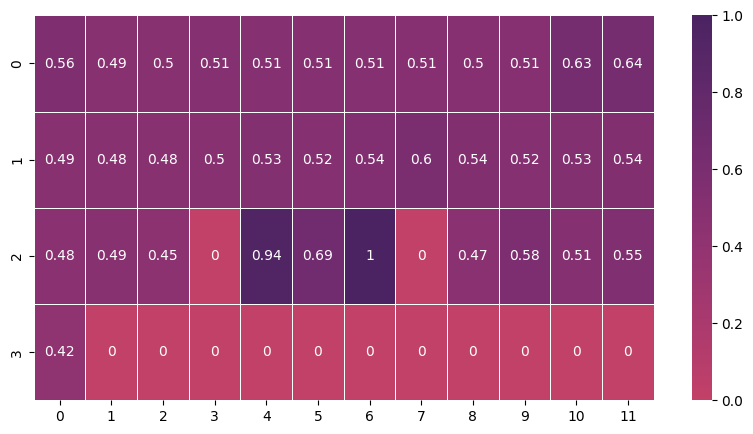

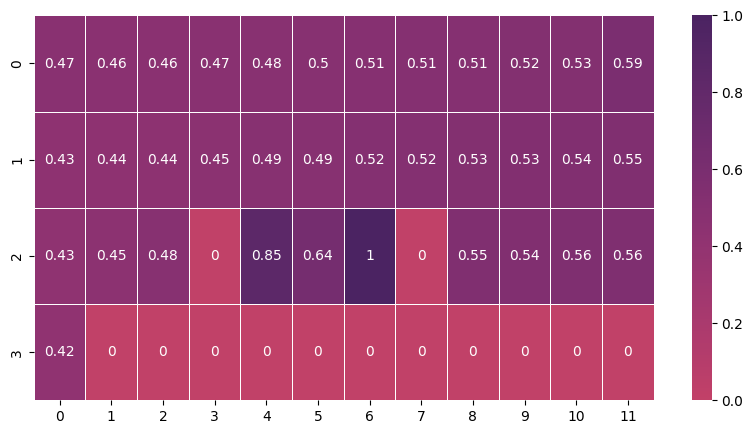

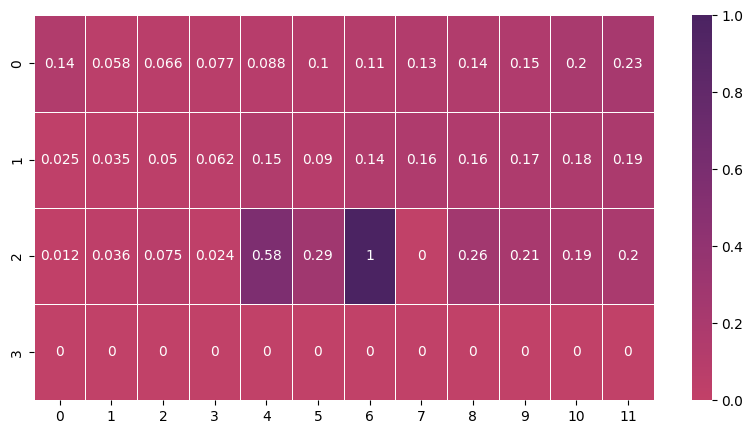

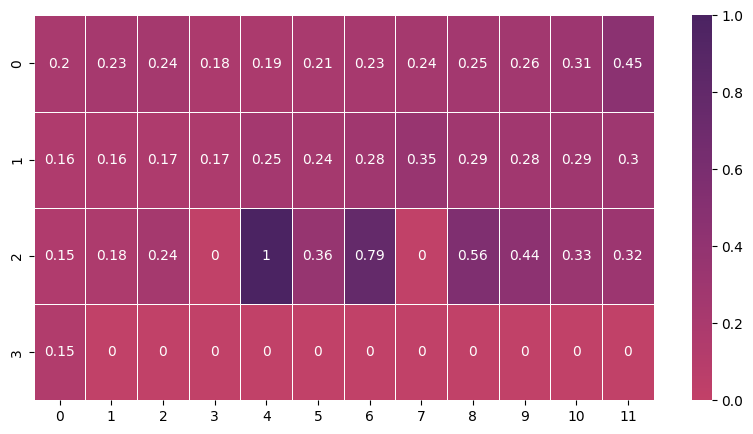

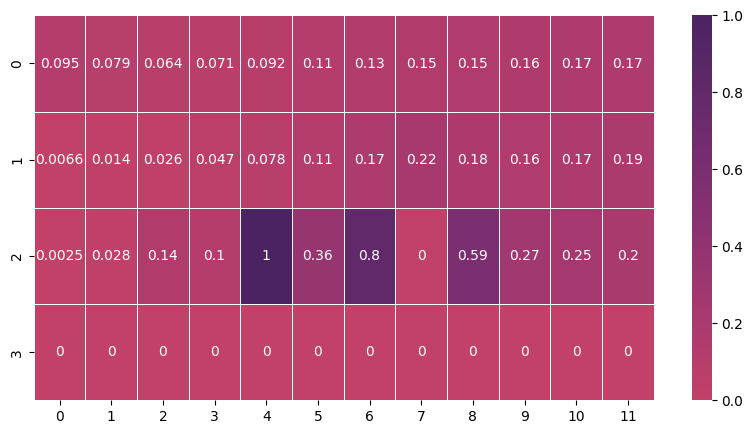

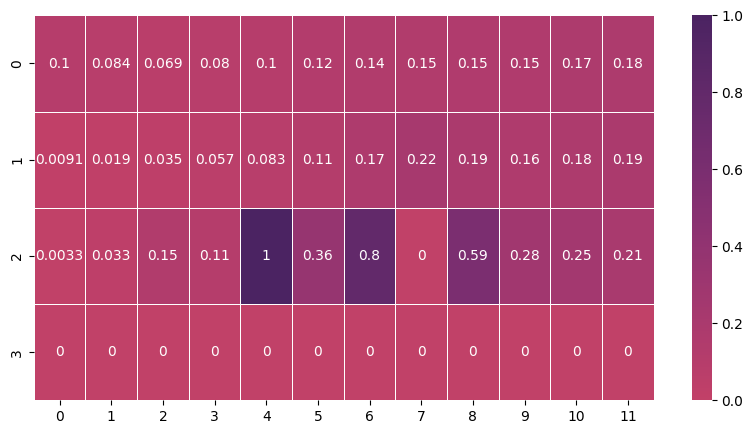

In [ ]:
######## TODO ########
# Plot the state-value fucntion using the learnt policy from SARSA
sarsa_Q, policy, stats = SARSA(cliffwalking, num_episodes=1000, episode_length=1000)
print("the state-value function from learned policy")
V = TD0(policy, cliffwalking, num_episodes=3000)
cliffwalking.plot_Vfunction(V)
######################

🛑 <mark>TODO:</mark>

From your observation of plots above, answer the following question in the following cell:

Q: Can you describe the optimal policies learnt by the RL algorithms? What do you observe from these plots?

Q: What do you find differently when you use MC and TD for different policies?

--------------

🛑 <mark>TODO: Answer</mark>

A1.
Random policy: Random policy calculate their state value function through random action and it always try to consider the -100 reward from cliff. So with this random policy, the optimal policy try to reach final state through far from cliff.

Q-learning: Q-learning use maximum value from next state. Therefore the optimal policy only consider the greedy cases. So the optimal policy is using the shortest path which right next to cliff.

SARSA: SARSA also consider the all possible actions from next state and it consider the -100 reward from cliff. Therfore optimal policy from SARSA try to reach final state through far from cliff.


A2. For Q-learning's property, the values for row number 2 with the MC have higher value than TD method. It means that MC use the real return value so it have lower bases and TD have higher basis than MC. On the other hand the values from MC method is not well continous because of high variance and TD method is well continous because of the low variance.

And also with the SARSA, MC method shows lower basis result than TD method and MC method show higher variance than TD method.


(No more than 100 words for each question)

--------------


🛑 <mark>TODO:</mark>

Answer the following question in the following cell:

Q: What is the difference between Q-Learning and SARSA? and when do you think it is good to use on-policy RL algorithm and when to use off-policy RL algorithm?



--------------

🛑 <mark>TODO: Answer</mark>

Difference between Q-Learning and SARSA: With Q-Learning, it is off-policy algorithm so it only consider the optimal cases and greedy cases. So it can earn high return. But with SARSA It s on-policy RL algorithm so it also consider the safety of states and it can take more longer path than Q-learning.

off-policy RL can be used in environment which have lower return for fail and situation which do not need to consider the fail. On-policy RL can be used in environment which have higher return for fail and situation which must consider the fail.

(No more than 100 words)



--------------
